## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'fft-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_fft_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\fft\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


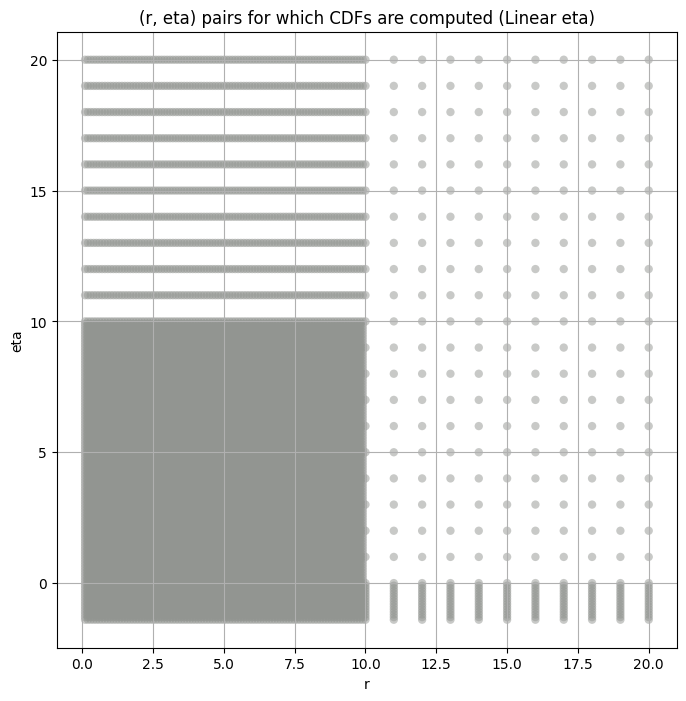

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,3.028180e+14,2.467996e+14,3.692888e+14,6.332603,2.811316,9.789408,672.0
5,7.008839e+14,6.244049e+14,7.815991e+14,16.975710,14.058760,20.035242,6720.0
8,1.720154e+14,1.501150e+14,1.960864e+14,24.927643,19.883404,30.177086,12768.0
11,1.050736e+13,9.690892e+12,1.152692e+13,9.357876,3.100183,21.787817,26208.0
14,2.555720e+14,2.280822e+14,2.856580e+14,17.237581,12.749988,23.402639,52416.0
17,4.594762e+14,4.331978e+14,4.878664e+14,3.241749,2.217288,6.229757,420672.0
20,3.257566e+13,3.055330e+13,3.482894e+13,4.369693,2.560891,8.748408,841344.0
23,6.163140e+12,5.720683e+12,6.830977e+12,9.159768,2.926370,42.885918,6730752.0
26,5.002160e+11,4.612606e+11,5.505253e+11,9.463871,4.324023,31.556948,3365376.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,3.028180e+14,3.028180e+14,1.778921e+14,1.433086e+14,1.196153e+14,1.028475e+14,7.676329e+13,5.682309e+13,4.320947e+13,3.308721e+13,2.459500e+13,5.769992e+12
5,7.008839e+14,7.008839e+14,5.675276e+14,4.975433e+14,4.440498e+14,3.991354e+14,3.285135e+14,2.772933e+14,2.393302e+14,2.098025e+14,1.863778e+14,1.405487e+14
8,1.720154e+14,1.720154e+14,1.447865e+14,1.285781e+14,1.165714e+14,1.073719e+14,9.294913e+13,8.212705e+13,7.351951e+13,6.664633e+13,6.107152e+13,4.981736e+13
11,1.050736e+13,1.050736e+13,9.809965e+12,9.533214e+12,9.314053e+12,9.121616e+12,8.816620e+12,8.575172e+12,8.368032e+12,8.184708e+12,8.024089e+12,7.621153e+12
14,2.555720e+14,2.555720e+14,2.427385e+14,2.345849e+14,2.277672e+14,2.219350e+14,2.121787e+14,2.037773e+14,1.965341e+14,1.901171e+14,1.842968e+14,1.695781e+14
17,4.594762e+14,4.594762e+14,4.499746e+14,4.440492e+14,4.389829e+14,4.344777e+14,4.265962e+14,4.196827e+14,4.134558e+14,4.077337e+14,4.024091e+14,3.881423e+14
20,3.257566e+13,3.257566e+13,3.166154e+13,3.115787e+13,3.075127e+13,3.039822e+13,2.978925e+13,2.926432e+13,2.879713e+13,2.837240e+13,2.798051e+13,2.694870e+13
23,6.163140e+12,6.163140e+12,5.927090e+12,5.823431e+12,5.740394e+12,5.668828e+12,5.546629e+12,5.442475e+12,5.350287e+12,5.266756e+12,5.190137e+12,4.989928e+12
26,5.002160e+11,5.002160e+11,4.796538e+11,4.696334e+11,4.617226e+11,4.549693e+11,4.434743e+11,4.337236e+11,4.250981e+11,4.173006e+11,4.101439e+11,3.915361e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.013957878634907661 302817993711258.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.029571751683703087 177892132790124.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.05154231015919941 143308571223930.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.07134799194567912 119615266403047.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08830682535070067 102847457831320.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.1216852613688234 76763286633314.92


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.15566679180243348 56823092389227.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.18501785542286842 43209466080857.63


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.2109498019253928 33087207372245.215


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.23639277476097276 24594995819570.76


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.34141503153382213 5769991546087.867
Number of samples: 1344, Without approximation : 672.0


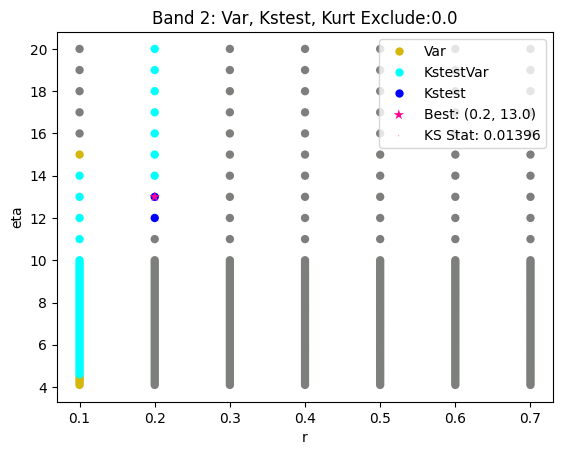

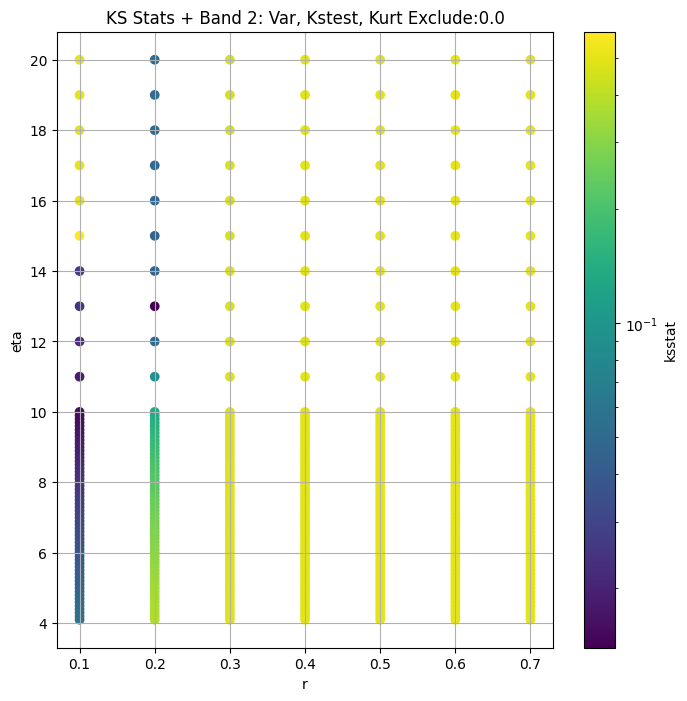

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.02669521705050365 700883940033422.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.022408172150472194 567527615899371.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.019511934612620574 497543300104577.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.017296583248497033 444049842342425.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.014971501194114292 399135364950537.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.016853780656958178 328513540518189.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.02005376606096554 277293298753756.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.022759760891097255 239330213363377.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0256007353080685 209802531296171.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.029053200254618366 186377774681815.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.039269372480552844 140548699383269.17
Number of samples: 13440, Without approximation : 6720.0


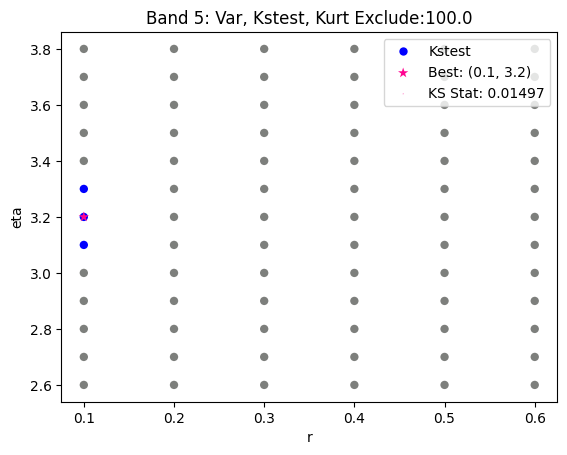

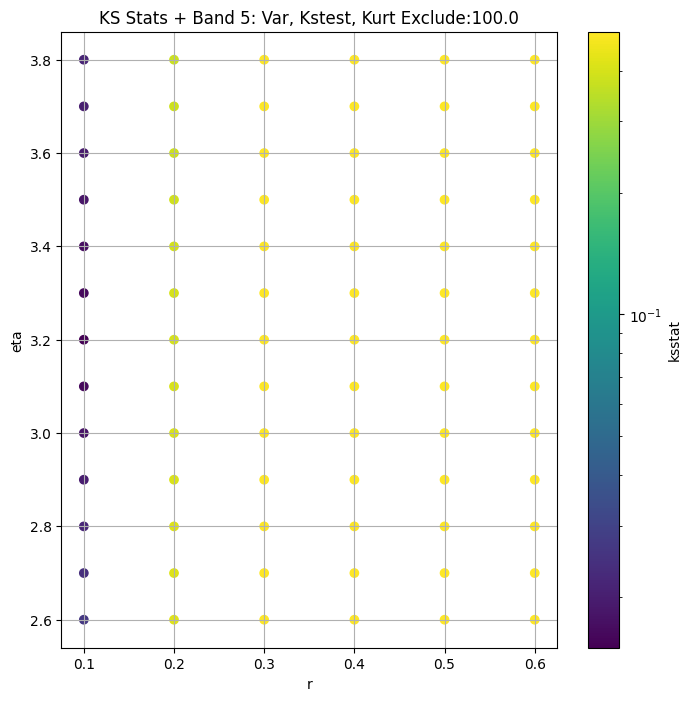

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.01957511384864541 172015403152260.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.01957511384864541 144786497902448.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01957511384864541 128578057169014.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.019443925129914247 116571351005083.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.017673855240189107 107371935290005.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01382222730556204 92949131814308.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011471145881970759 82127051926120.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013172068206814935 73519512583905.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.01453985313083117 66646331867860.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01637594584887181 61071516918729.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.021967245532834946 49817356345718.65
Number of samples: 25536, Without approximation : 12768.0


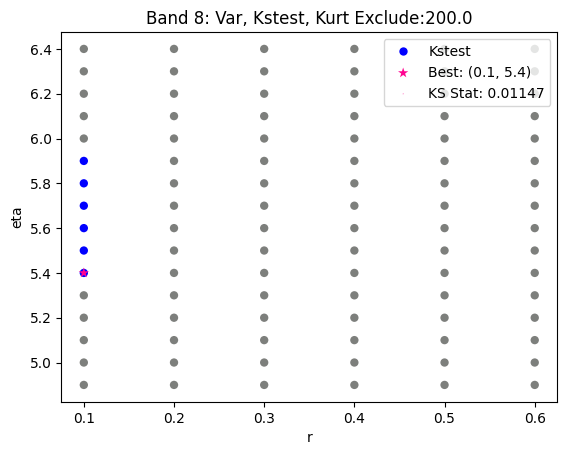

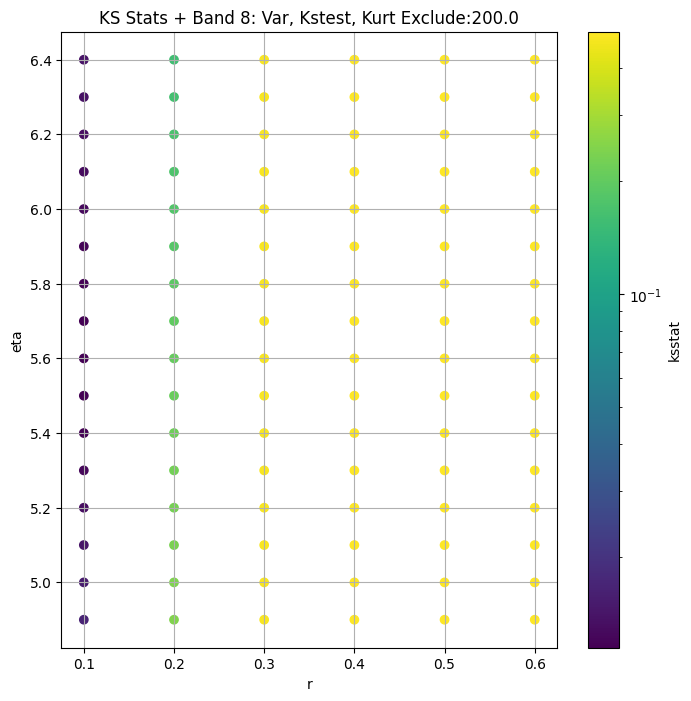

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007695034116308119 10507361596511.855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.005194894889528512 9809964918444.195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.003873446199499725 9533213599391.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0032940039840549523 9314052533056.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0030952794188253826 9121615721928.588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0039322796988260356 8816619815235.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0050976335009012 8575172095126.997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.005946124771885931 8368031865933.743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.007734999795212999 8184707754358.025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.009951984209150888 8024089013629.785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.01582079077495846 7621152784065.424
Number of samples: 52416, Without approximation : 26208.0


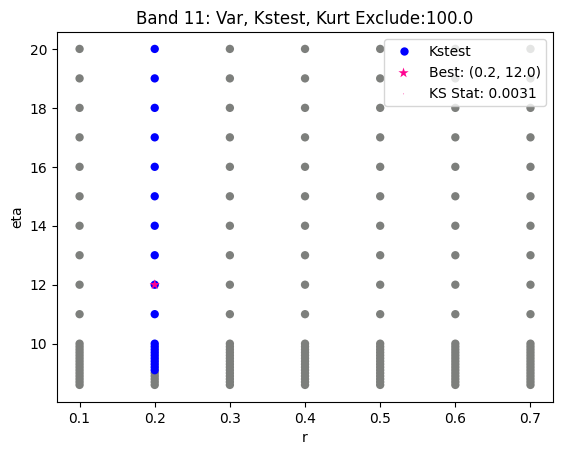

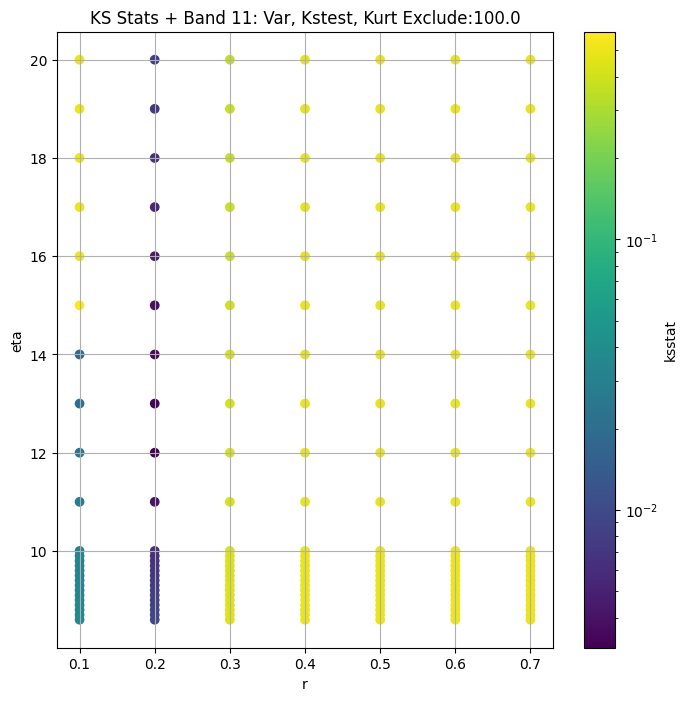

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.01882705189867849 255571956629778.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02102478475314136 242738544687803.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.019812092595444586 234584853399767.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02086888832324965 227767165648005.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.021984834729655095 221935003186494.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.02156546172455276 212178741808233.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.023079501869243013 203777285838655.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.024124056863251586 196534137483904.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.023755264213829924 190117099671216.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.025109709355087648 184296847182331.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.02663850315558708 169578057086218.62
Number of samples: 100000, Without approximation : 52416.0


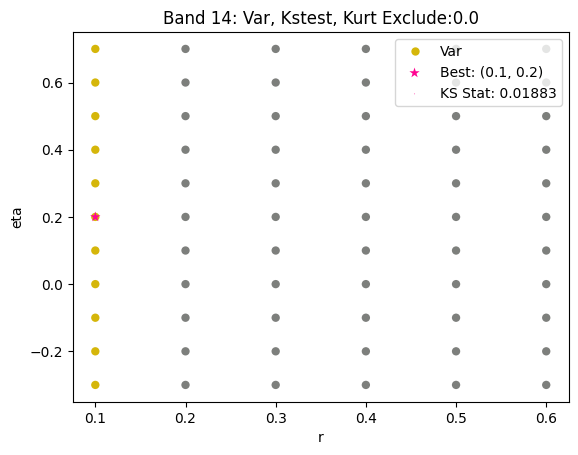

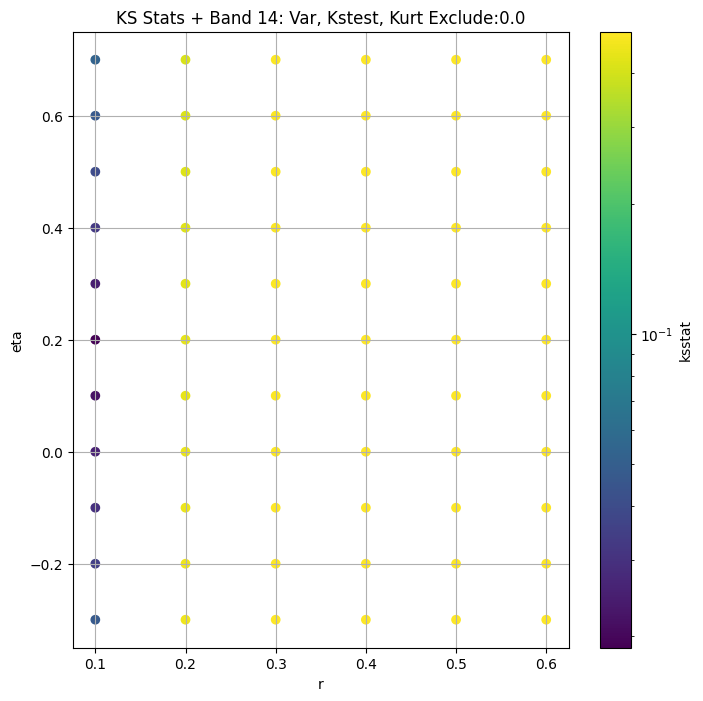

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.0072257679674621045 459476188667493.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.007709113291256023 449974646342802.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.008111275746993288 444049188541166.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.008459444549313785 438982882063475.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.008758993915438523 434477684153640.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.009601413528542463 426596185562322.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.010472876292243694 419682733748864.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.010764821623340887 413455844306876.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.011155071270411376 407733695068066.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.011837864323924044 402409134923261.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.01300660821771539 388142271343187.9
Number of samples: 100000, Without approximation : 420672.0


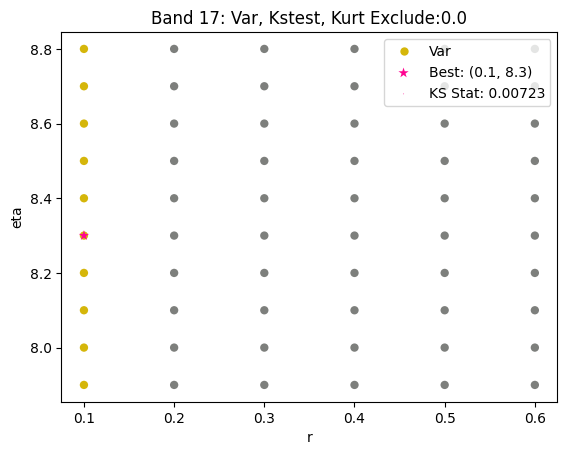

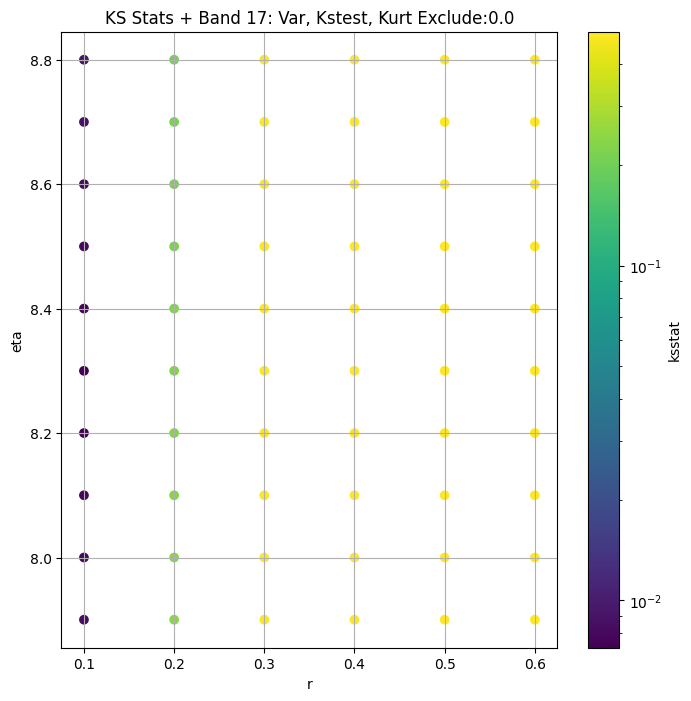

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.002031412375880115 32575664546854.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0012024039400286846 31661540483913.68


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0011895767292597996 31157867395909.188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0017846231477151968 30751273427573.96


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0023159306723257306 30398217576533.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0032910962865643767 29789246803764.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004142472323560742 29264323251774.59


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004936470838482081 28797125392402.598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.00563016207516099 28372399405483.535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006252524283885279 27980511991772.355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.008297293586766709 26948696251072.816
Number of samples: 100000, Without approximation : 841344.0


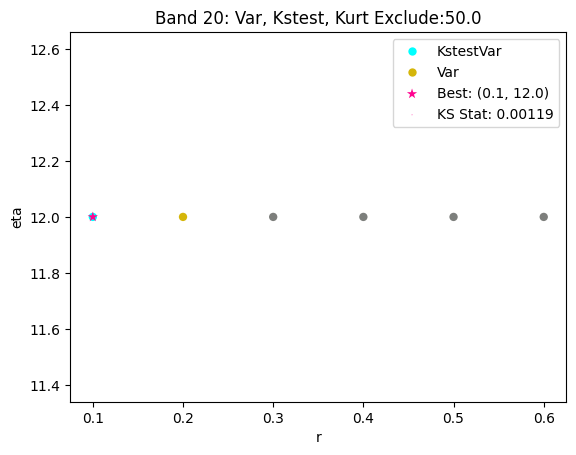

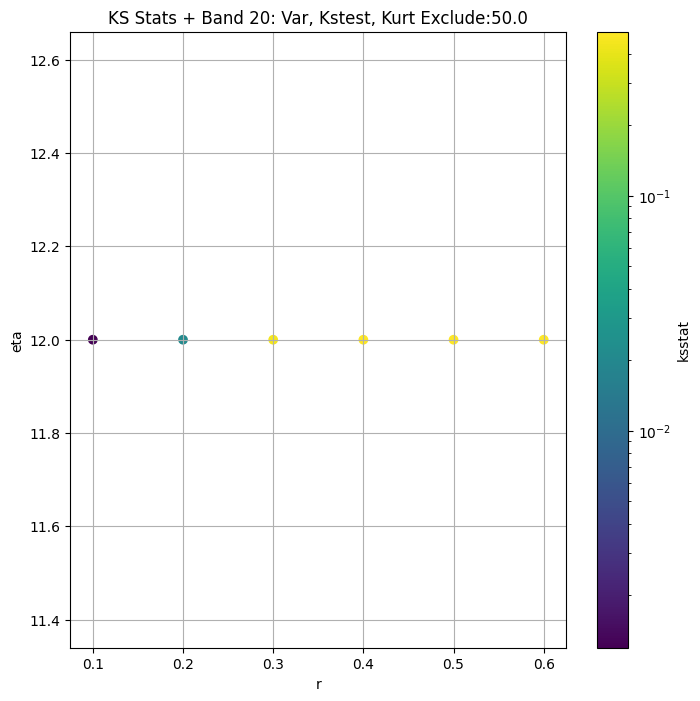

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0029824746575131122 6163140075661.676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0020113412370166284 5927089866016.788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0013286904276501588 5823431301772.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0015060053207299195 5740394344343.402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018407668462890187 5668827514951.624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0025674657145442863 5546628772029.292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0033128573225382207 5442474626424.315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.0041426996676993955 5350287294363.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.004950252183328105 5266756376334.423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.005723430345398031 5190136855556.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.007879758171781277 4989927760011.982
Number of samples: 100000, Without approximation : 6730752.0


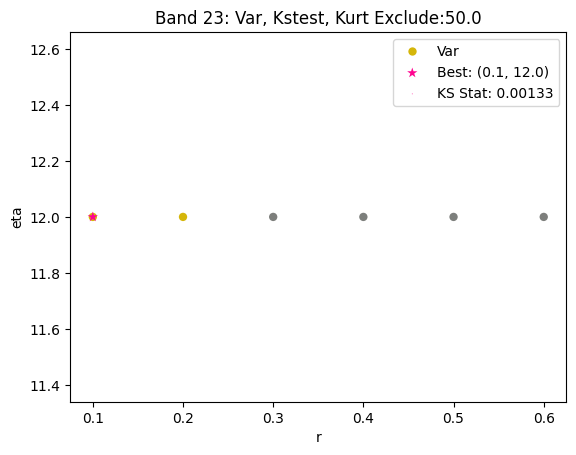

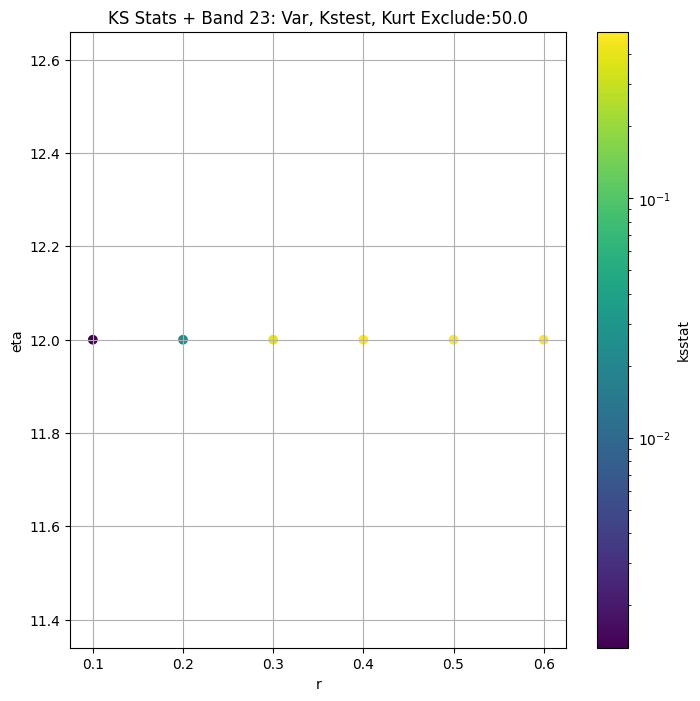

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0017182963509119742 500215952198.6477


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0009663662283030429 479653750222.0358


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0013956656802710365 469633372272.939


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0019190039683627397 461722619296.7584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.002453159143676102 454969268433.2959


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0034538068783211556 443474312224.70966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004369079593677206 433723581053.7338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.0052237254662288735 425098115829.31256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006033187736629905 417300575573.10034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006806564965462038 410143861332.5232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009011883842651912 391536137241.21674
Number of samples: 100000, Without approximation : 3365376.0


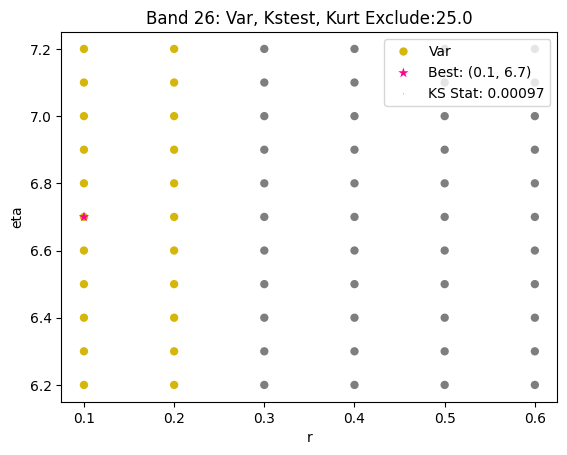

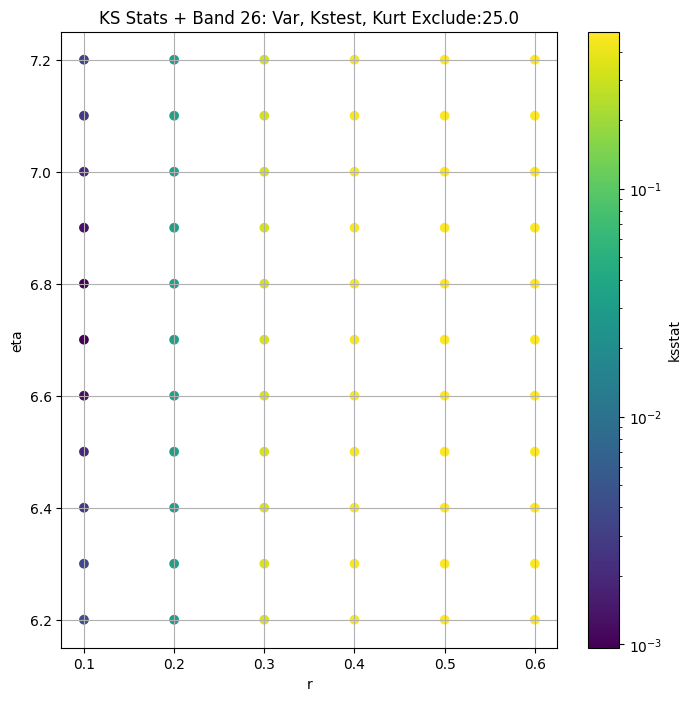

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.004043363385044296 46186738214.56651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.0033738900438873842 44094600986.49531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0028543029152086064 42942608355.070435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.0032090578108640577 42015289949.29916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.00372680415629505 41215788433.75869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.004147794315077079 39854789992.256355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.005026997591941956 38700681994.818054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.0058640296489547855 37688244490.46093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.006645467428494083 36781193237.6992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.007399821007734703 35956612322.28968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.00955348462815218 33835072785.824898
Number of samples: 100000, Without approximation : 6730752.0


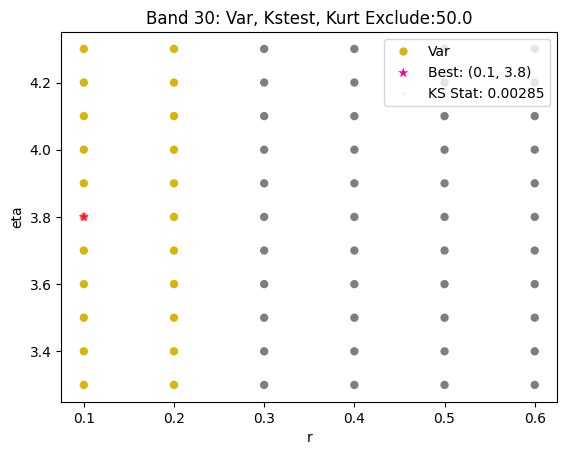

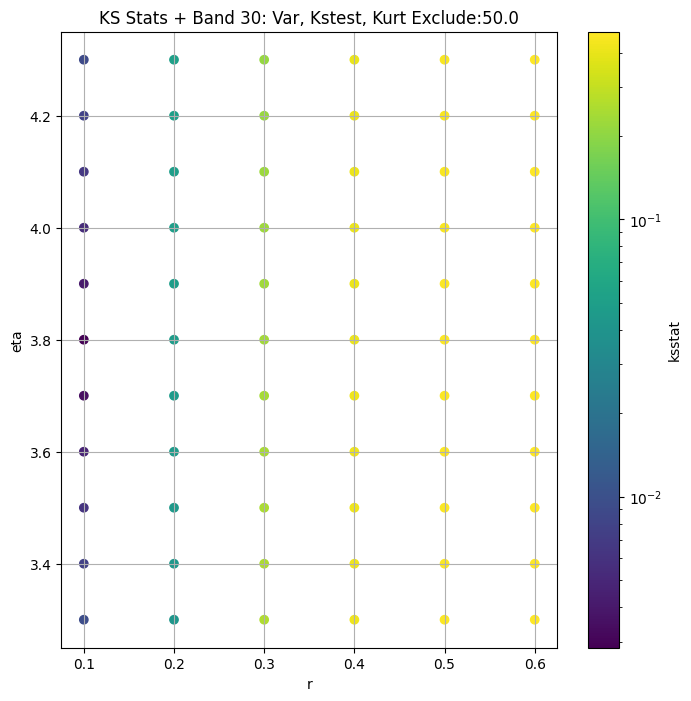

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,3.028180e+14,2.467996e+14,3.692888e+14,6.332603,2.811316,9.789408,672.0,0.013958,0.2,13.0,1.000000e+05,0.0,3.028180e+14,0.052135
5,7.008839e+14,6.244049e+14,7.815991e+14,16.975710,14.058760,20.035242,6720.0,0.014972,0.1,3.2,3.089023e-03,100.0,3.991354e+14,0.016542
8,1.720154e+14,1.501150e+14,1.960864e+14,24.927643,19.883404,30.177086,12768.0,0.011471,0.1,5.4,1.798595e-05,200.0,8.212705e+13,0.012006
11,1.050736e+13,9.690892e+12,1.152692e+13,9.357876,3.100183,21.787817,26208.0,0.003095,0.2,12.0,5.631155e+03,100.0,9.121616e+12,0.008383
14,2.555720e+14,2.280822e+14,2.856580e+14,17.237581,12.749988,23.402639,52416.0,0.018827,0.1,0.2,1.325909e+01,0.0,2.555720e+14,0.005929
17,4.594762e+14,4.331978e+14,4.878664e+14,3.241749,2.217288,6.229757,420672.0,0.007226,0.1,8.3,3.603551e-06,0.0,4.594762e+14,0.002094
20,3.257566e+13,3.055330e+13,3.482894e+13,4.369693,2.560891,8.748408,841344.0,0.001190,0.1,12.0,1.118785e-08,50.0,3.115787e+13,0.001480
23,6.163140e+12,5.720683e+12,6.830977e+12,9.159768,2.926370,42.885918,6730752.0,0.001329,0.1,12.0,2.091018e-09,50.0,5.823431e+12,0.000523
26,5.002160e+11,4.612606e+11,5.505253e+11,9.463871,4.324023,31.556948,3365376.0,0.000966,0.1,6.7,2.056664e-08,25.0,4.796538e+11,0.000740


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.09480727022866606, var: 102847457831320.31


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.07809834752738709, var: 119615266403047.2


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.05846336815149633, var: 143308571223930.4


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.0357364908961646, var: 177892132790124.62


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.013957878634907661, var: 302817993711258.0
Number of samples: 1344, Without approximation : 672.0


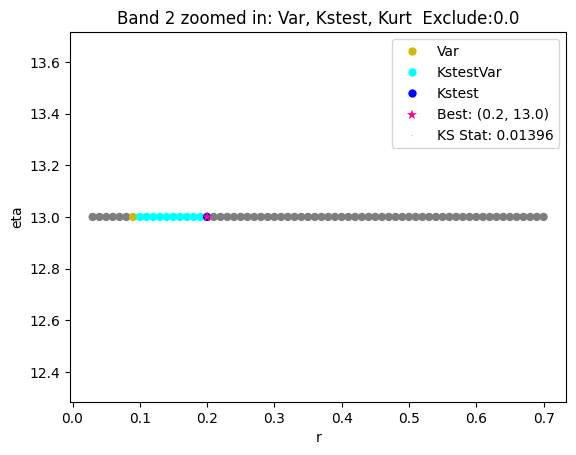

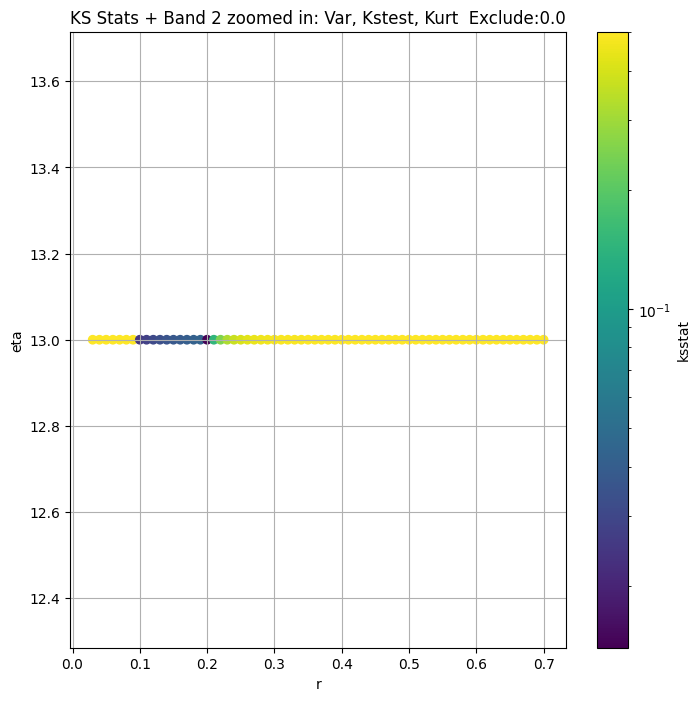

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.020021063994159483, var: 277293298753756.34


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.01853266089823835, var: 300794430364082.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.01681993386628504, var: 328513540518189.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.014923189759990851, var: 360624268425128.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.014971501194114292, var: 399135364950537.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.016985639330692692, var: 444049842342425.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.019113237922465165, var: 497543300104577.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.02025023855842545, var: 567527615899371.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.02025023855842545, var: 700883940033422.8
Number of samples: 13440, Without approximation : 6720.0


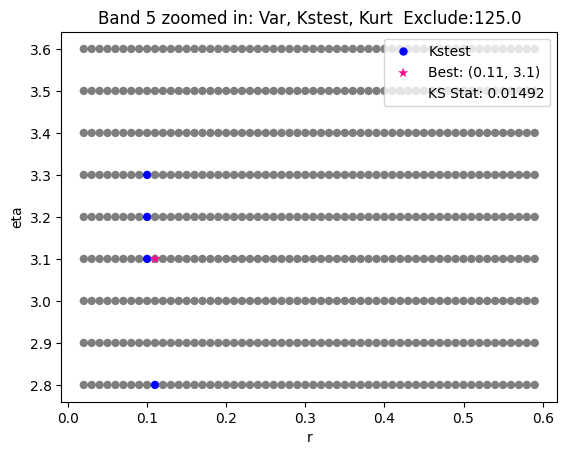

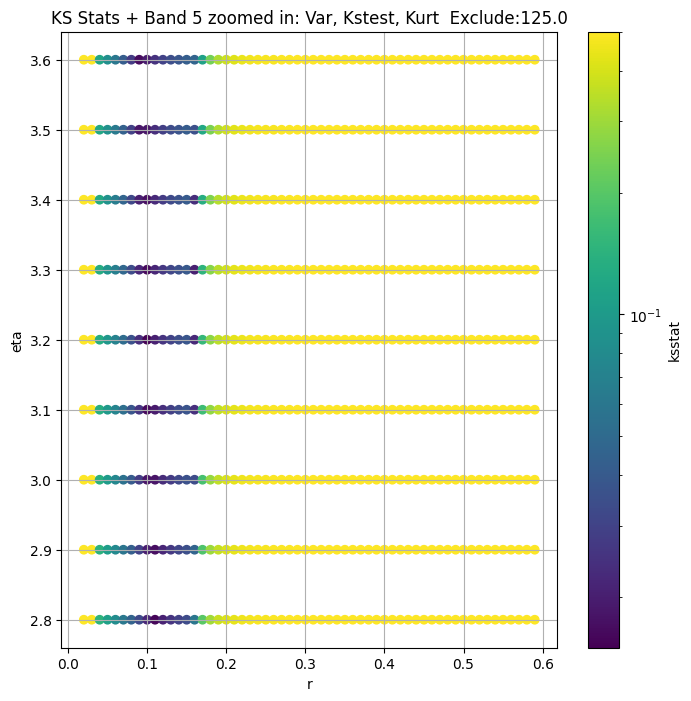

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.014576819251452305, var: 66646331867860.98


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.013923345718244273, var: 69943075355558.09


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.013184830988868707, var: 73519512583905.34


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.012374376523791142, var: 77526216109885.31


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.011471145881970759, var: 82127051926120.81


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.011998807156198277, var: 87206291420835.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.013749323086343135, var: 92949131814308.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.015262566398886568, var: 99682515893996.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.01536063665101095, var: 107371935290005.95
Number of samples: 25536, Without approximation : 12768.0


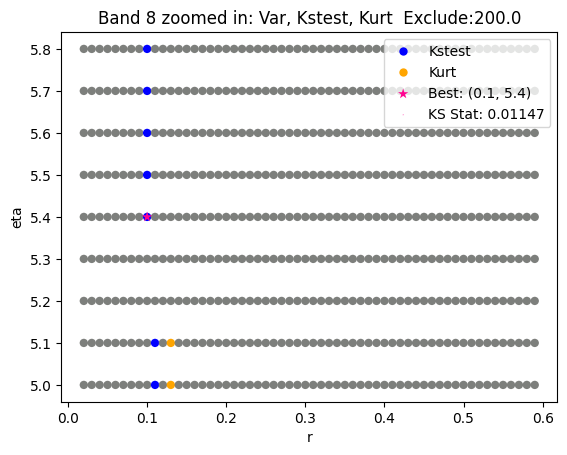

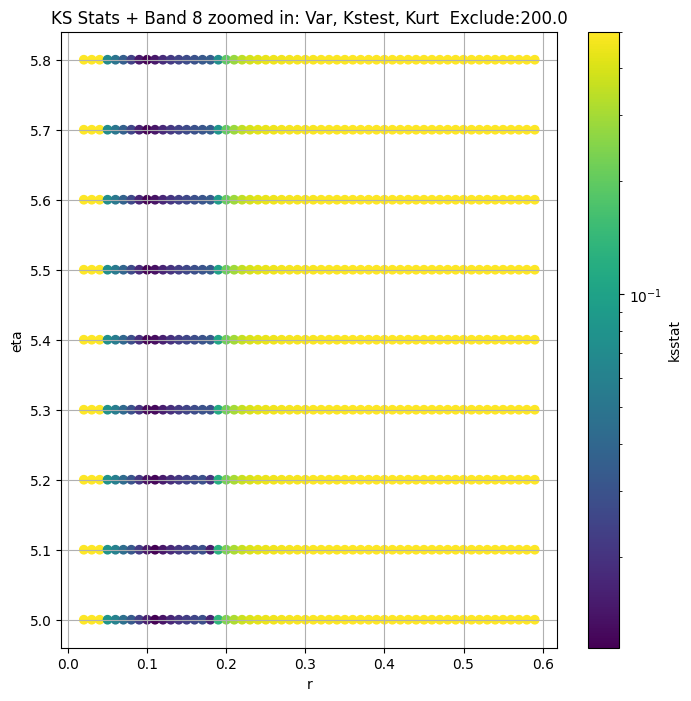

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 100 = 200, ksstat: 0.007704323409997937, var: 8575172095126.997


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 75 = 175, ksstat: 0.0062156175082639376, var: 8690547570284.145


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 50 = 150, ksstat: 0.004610134676822364, var: 8816619815235.375


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 25 = 125, ksstat: 0.003516186637490426, var: 8956505332898.322


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + 0 = 100, ksstat: 0.0030952794188253826, var: 9121615721928.588


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -25 = 75, ksstat: 0.002965385829334477, var: 9314052533056.547


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -50 = 50, ksstat: 0.0038795655408765395, var: 9533213599391.14


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -75 = 25, ksstat: 0.005164958764381625, var: 9809964918444.195


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 100.0 + -100 = 0, ksstat: 0.008318343301725449, var: 10507361596511.855
Number of samples: 52416, Without approximation : 26208.0


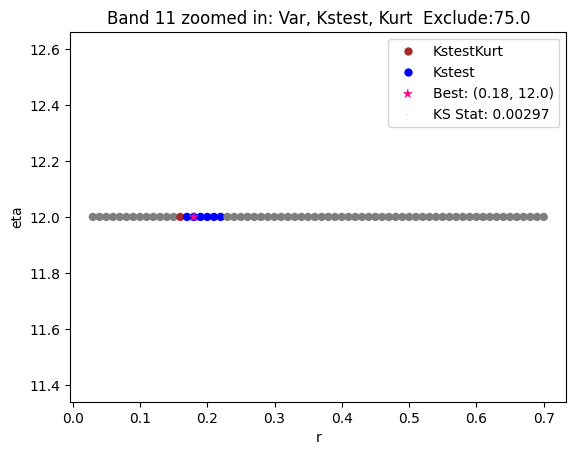

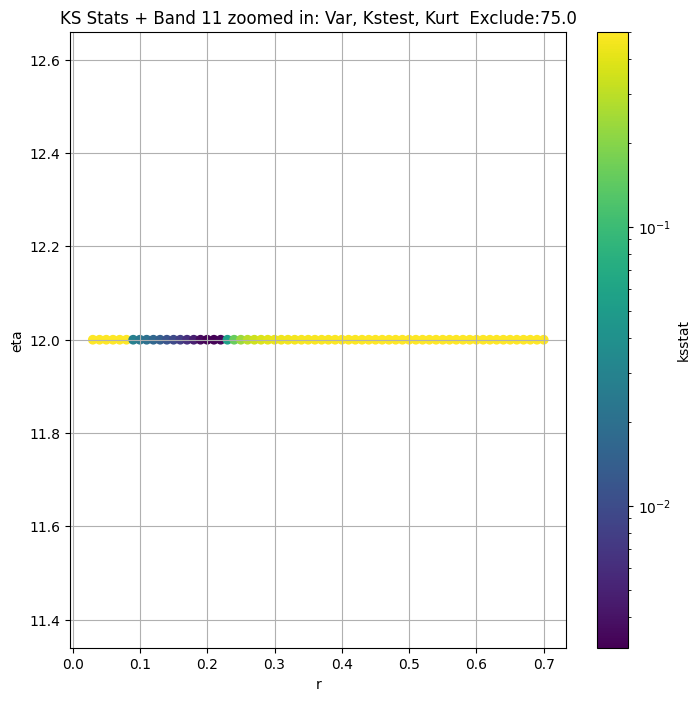

Band 14


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.019773952892132074, var: 221935003186494.84


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.020822610922441018, var: 227767165648005.0


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.019547490579768997, var: 234584853399767.06


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.019222974445651186, var: 242738544687803.28


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.017929249488681576, var: 255571956629778.5
Number of samples: 100000, Without approximation : 52416.0


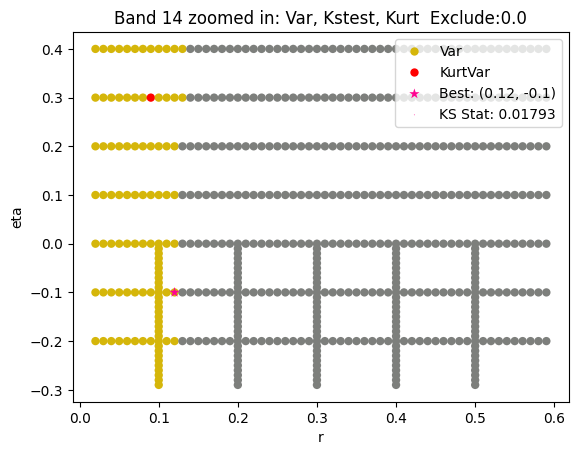

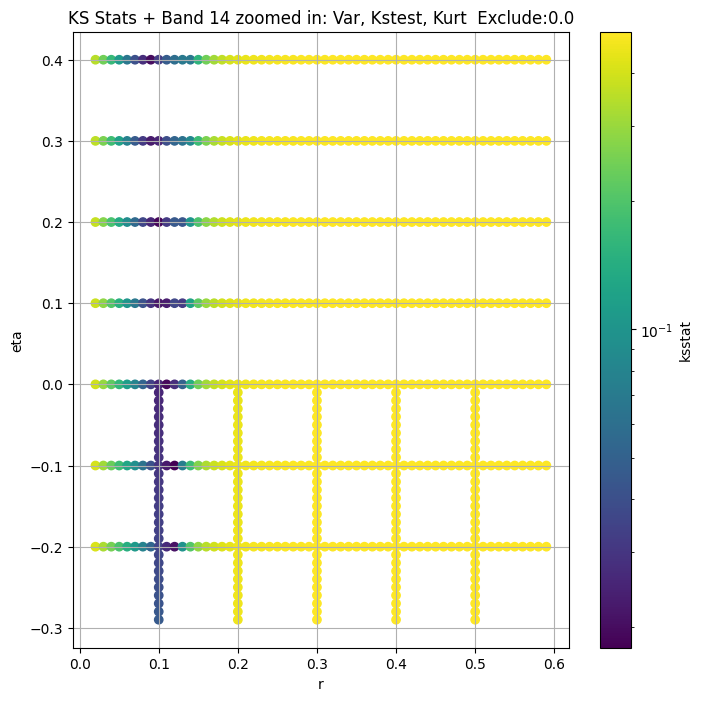

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.008626343575960982, var: 434477684153640.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.00837435554546219, var: 438982882063475.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.008039423249160071, var: 444049188541166.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.007709113291256023, var: 449974646342802.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.0072257679674621045, var: 459476188667493.56
Number of samples: 100000, Without approximation : 420672.0


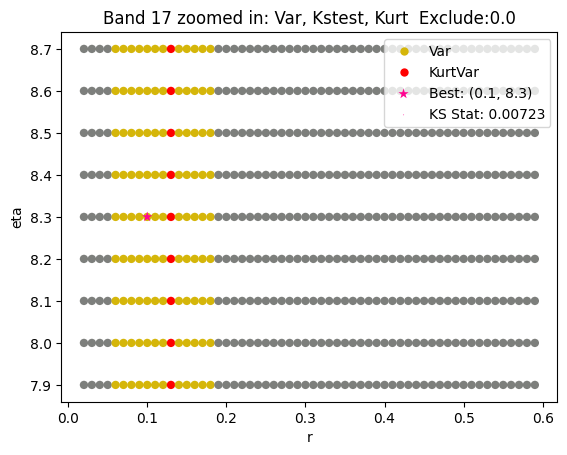

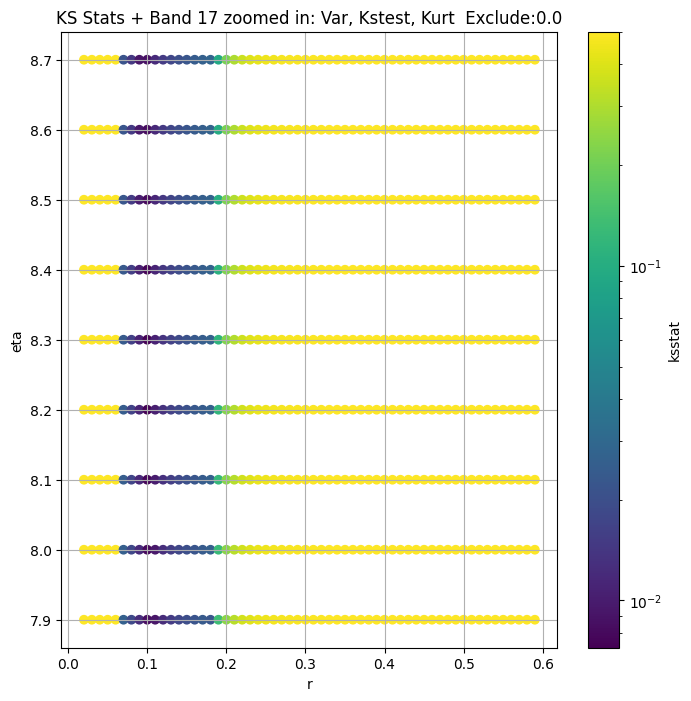

Band 20


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.0032432092798143908, var: 29789246803764.0


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.0027921773187136872, var: 30080595429363.402


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.0023009932550271325, var: 30398217576533.78


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.002000599389438973, var: 30751273427573.96


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.0011895767292597996, var: 31157867395909.188


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.0012024039400286846, var: 31661540483913.68


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.0015770079961043848, var: 32575664546854.03
Number of samples: 100000, Without approximation : 841344.0


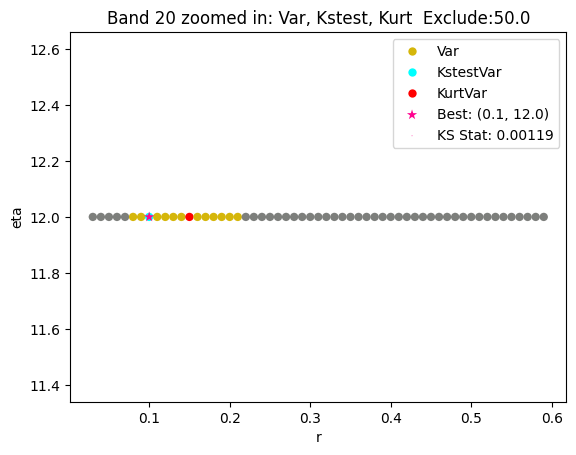

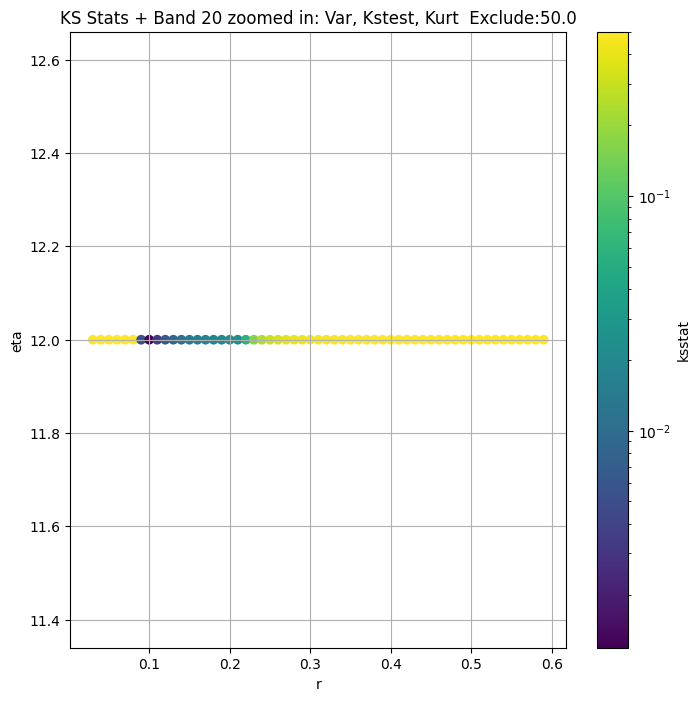

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.002752053580306932, var: 5546628772029.292


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.00240980812590421, var: 5604911232714.064


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.002079262990829932, var: 5668827514951.624


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0015060053207299195, var: 5740394344343.402


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0013286904276501588, var: 5823431301772.19


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.003067552651292993, var: 5927089866016.788


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.003992876176486138, var: 6163140075661.676
Number of samples: 100000, Without approximation : 6730752.0


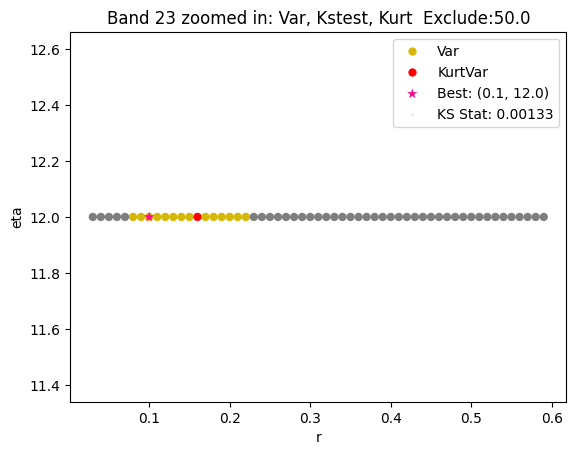

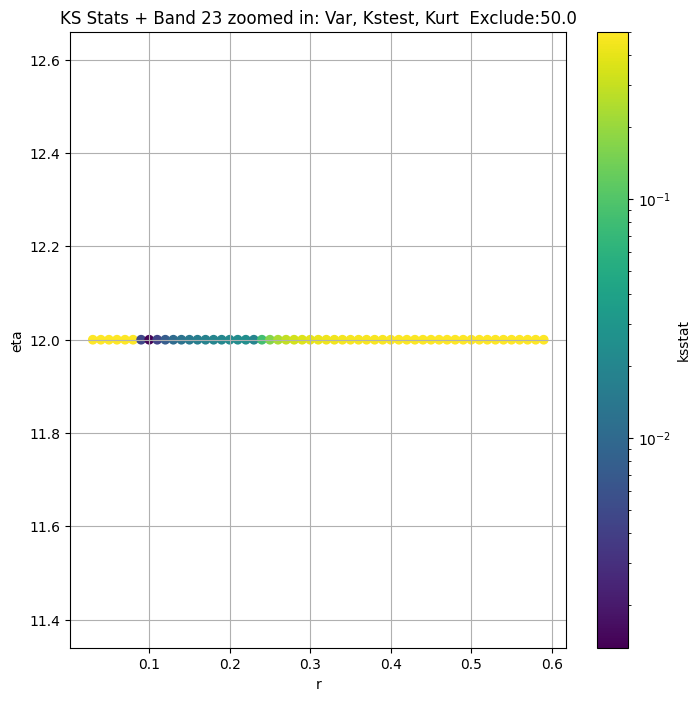

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.0032526658968475425, var: 448954141768.8883


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.0027757257426014106, var: 454969268433.2959


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.0022266536826482664, var: 461722619296.7584


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0016240348699435546, var: 469633372272.939


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.0009663662283030429, var: 479653750222.0358


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.001457440967240431, var: 500215952198.6477
Number of samples: 100000, Without approximation : 3365376.0


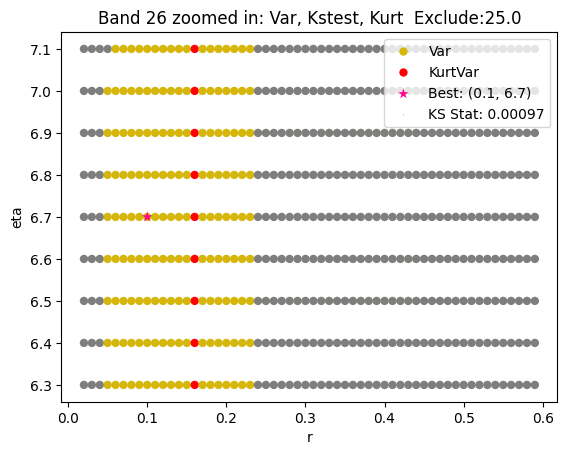

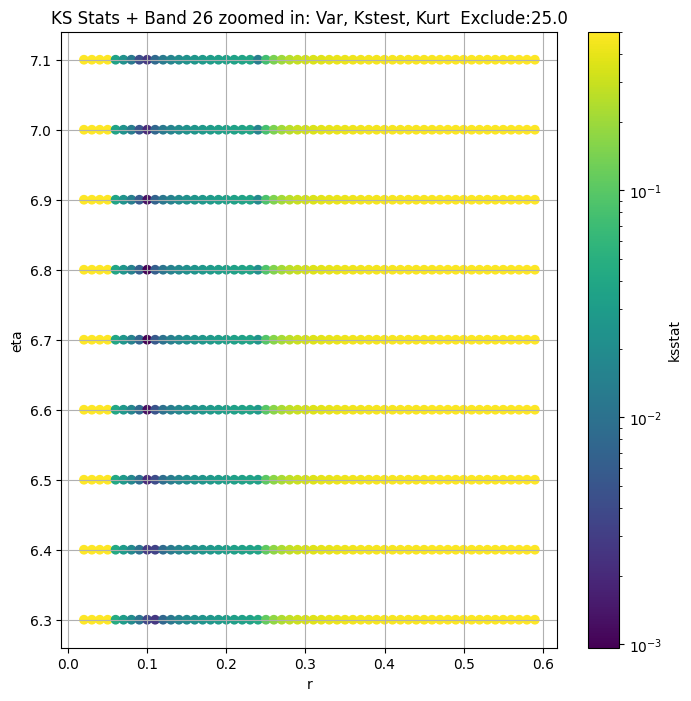

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 100 = 150, ksstat: 0.0045587650688187, var: 39854789992.256355


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 75 = 125, ksstat: 0.004161944691400677, var: 40502855162.45083


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 50 = 100, ksstat: 0.0036466042992874675, var: 41215788433.75869


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 25 = 75, ksstat: 0.0031318755363436597, var: 42015289949.29916


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + 0 = 50, ksstat: 0.0028543029152086064, var: 42942608355.070435


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + -25 = 25, ksstat: 0.0031444206326510793, var: 44094600986.49531


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 50.0 + -50 = 0, ksstat: 0.004043363385044296, var: 46186738214.56651
Number of samples: 100000, Without approximation : 6730752.0


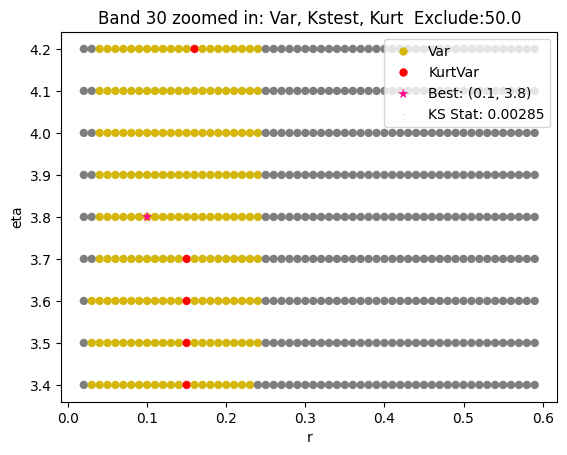

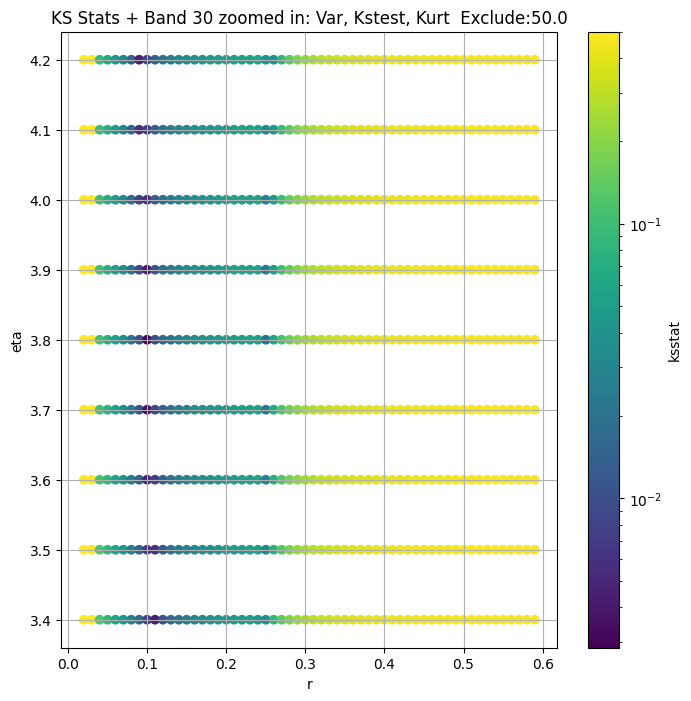

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,3.028180e+14,2.467996e+14,3.692888e+14,6.332603,2.811316,9.789408,672.0,0.013958,0.2,13.0,1.000000e+05,0.0,3.028180e+14,0.052135,0.013958,0.20,13.0,1.000000e+05,0.0,9685
5,7.008839e+14,6.244049e+14,7.815991e+14,16.975710,14.058760,20.035242,6720.0,0.014972,0.1,3.2,3.089023e-03,100.0,3.606243e+14,0.016542,0.014923,0.11,3.1,2.878721e-01,125.0,8505
8,1.720154e+14,1.501150e+14,1.960864e+14,24.927643,19.883404,30.177086,12768.0,0.011471,0.1,5.4,1.798595e-05,200.0,8.212705e+13,0.012006,0.011471,0.10,5.4,1.798595e-05,200.0,14364
11,1.050736e+13,9.690892e+12,1.152692e+13,9.357876,3.100183,21.787817,26208.0,0.003095,0.2,12.0,5.631155e+03,100.0,9.314053e+12,0.008383,0.002965,0.18,12.0,3.023077e+02,75.0,212521
14,2.555720e+14,2.280822e+14,2.856580e+14,17.237581,12.749988,23.402639,52416.0,0.018827,0.1,0.2,1.325909e+01,0.0,2.555720e+14,0.005929,0.017929,0.12,-0.1,3.733190e+04,0.0,5527
17,4.594762e+14,4.331978e+14,4.878664e+14,3.241749,2.217288,6.229757,420672.0,0.007226,0.1,8.3,3.603551e-06,0.0,4.594762e+14,0.002094,0.007226,0.10,8.3,3.603551e-06,0.0,35529
20,3.257566e+13,3.055330e+13,3.482894e+13,4.369693,2.560891,8.748408,841344.0,0.001190,0.1,12.0,1.118785e-08,50.0,3.115787e+13,0.001480,0.001190,0.10,12.0,1.118785e-08,50.0,1262016
23,6.163140e+12,5.720683e+12,6.830977e+12,9.159768,2.926370,42.885918,6730752.0,0.001329,0.1,12.0,2.091018e-09,50.0,5.823431e+12,0.000523,0.001329,0.10,12.0,2.091018e-09,50.0,1064826
26,5.002160e+11,4.612606e+11,5.505253e+11,9.463871,4.324023,31.556948,3365376.0,0.000966,0.1,6.7,2.056664e-08,25.0,4.796538e+11,0.000740,0.000966,0.10,6.7,2.056664e-08,25.0,1893024


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

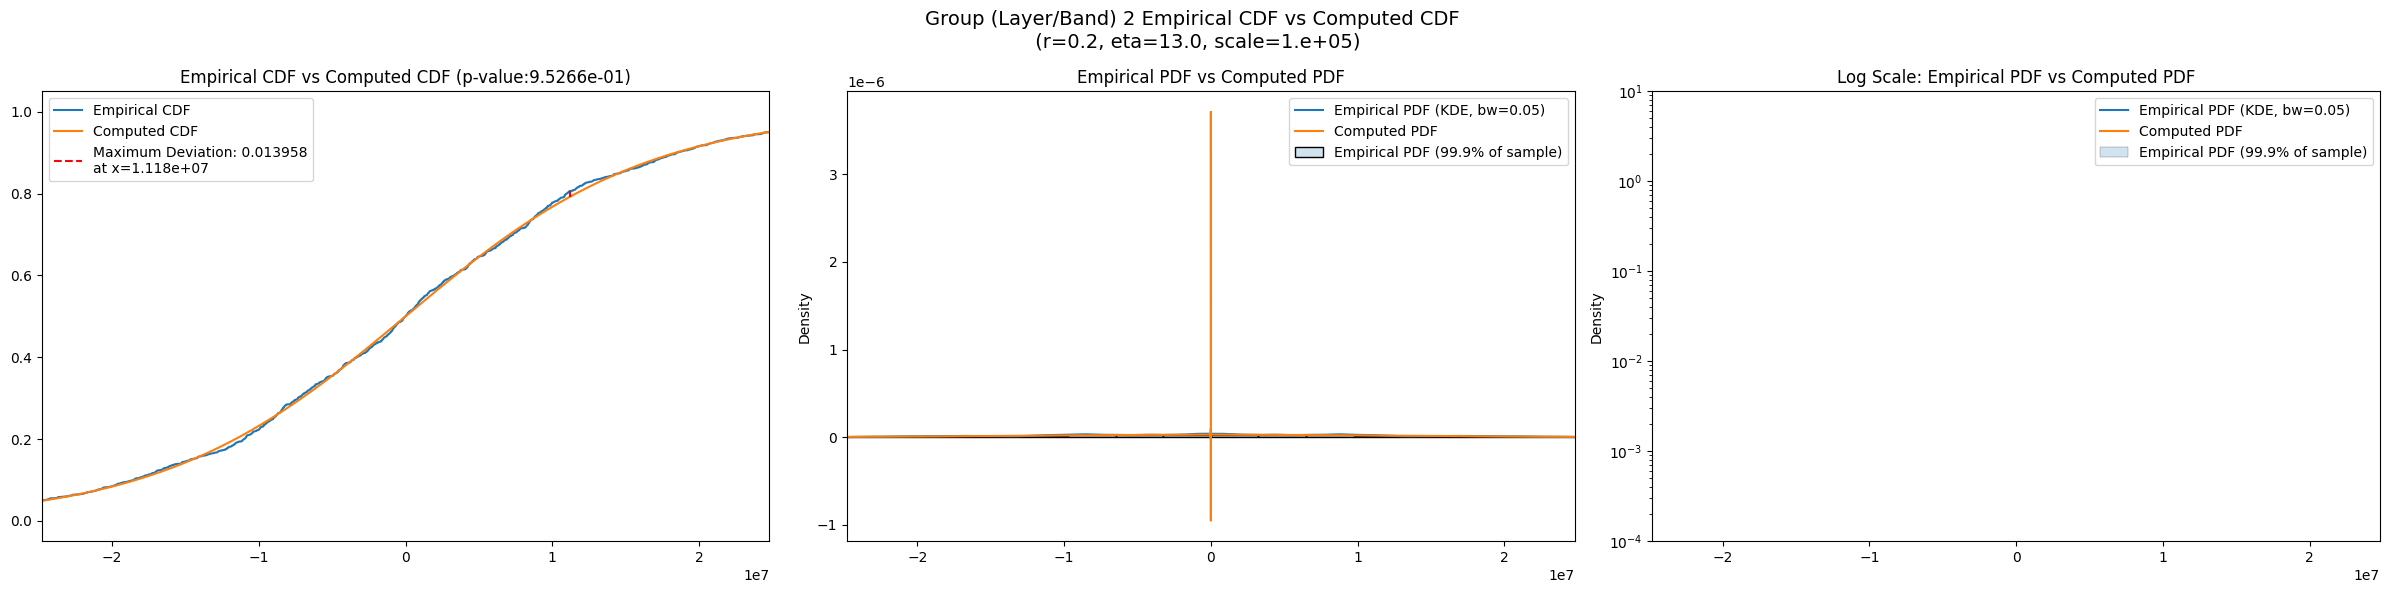

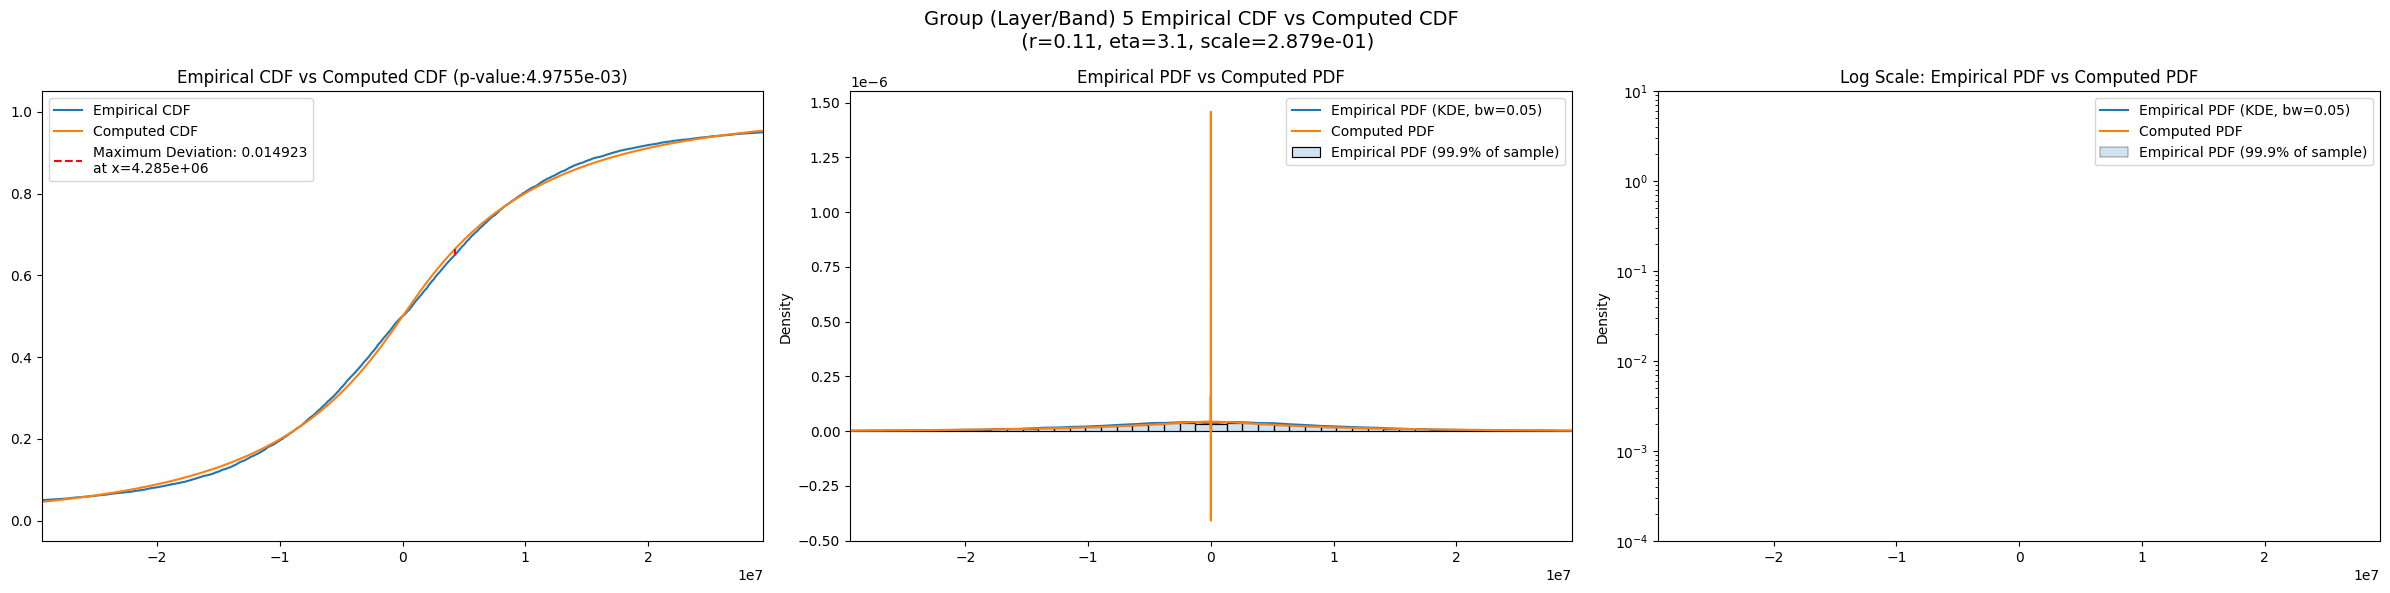

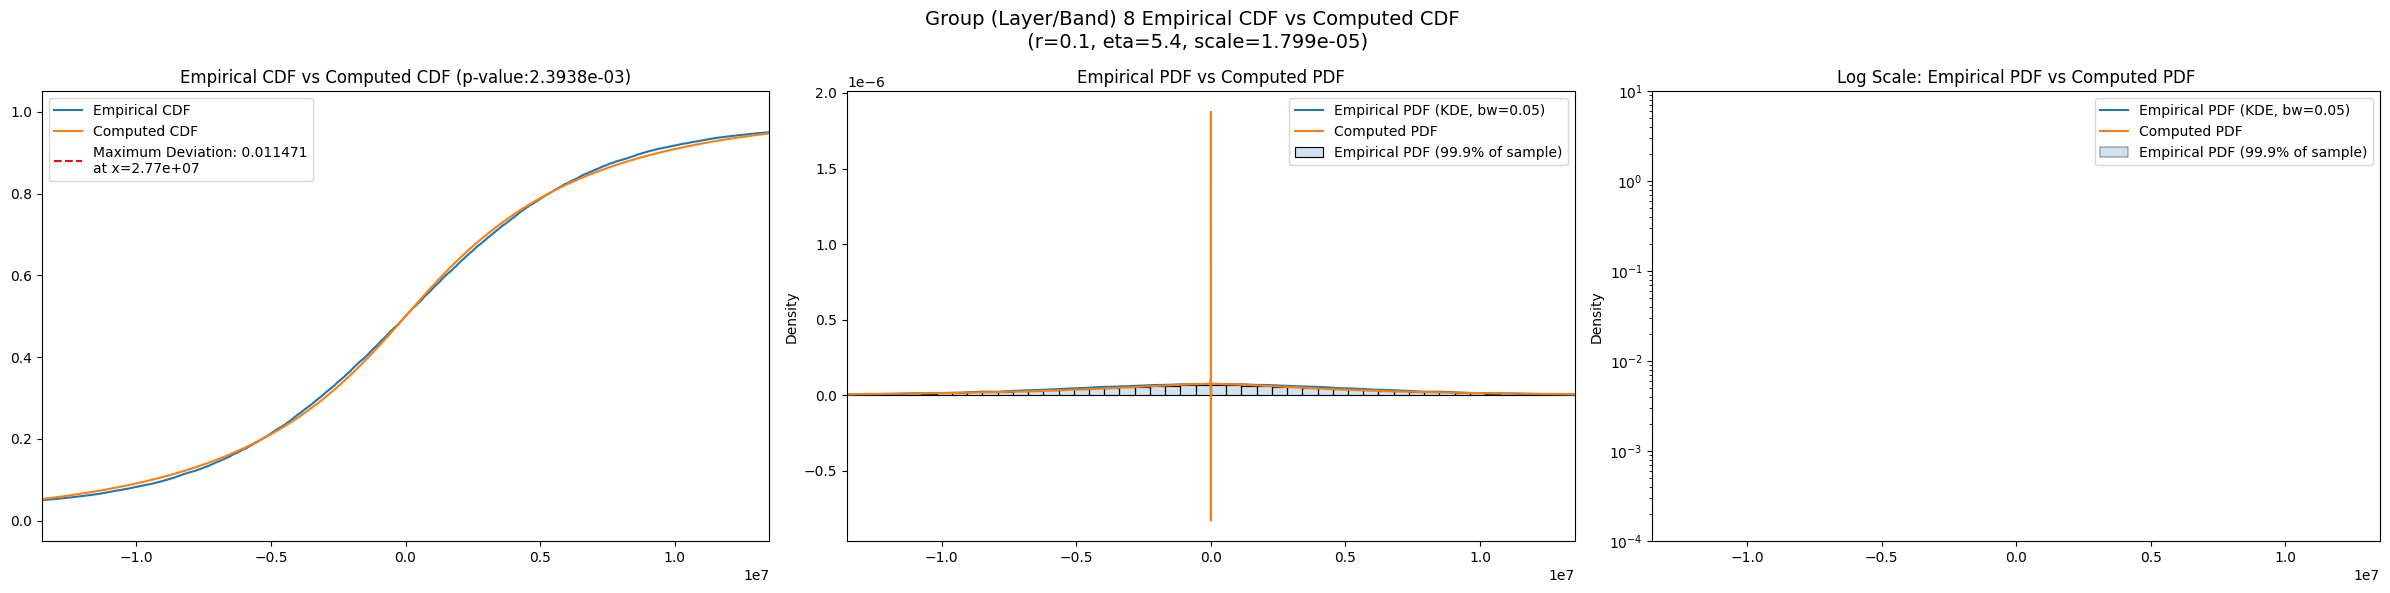

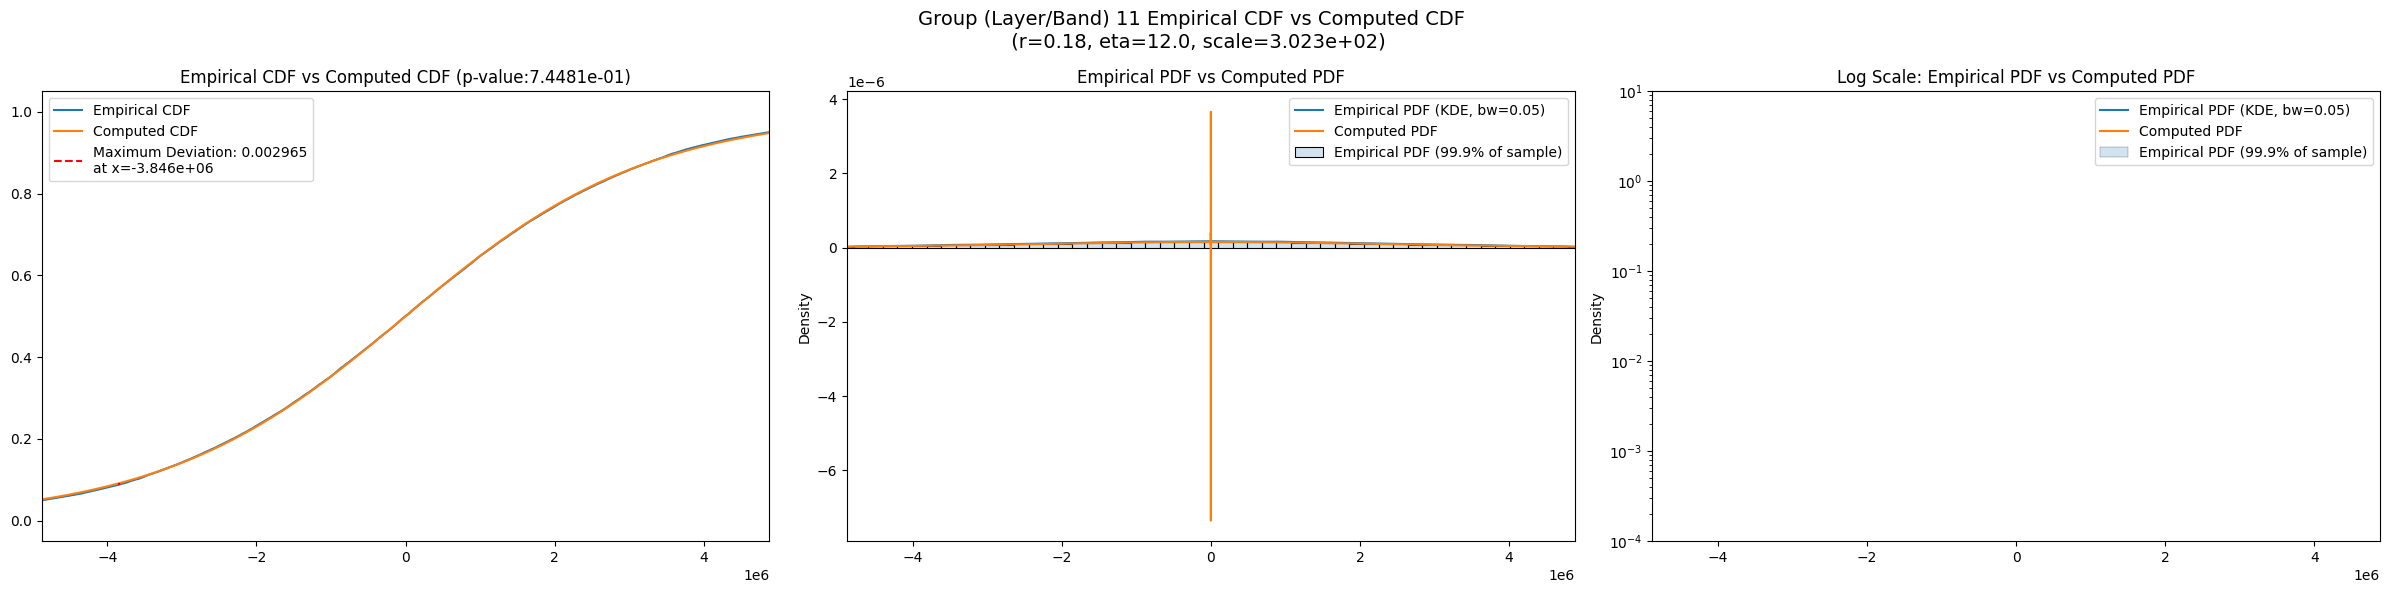

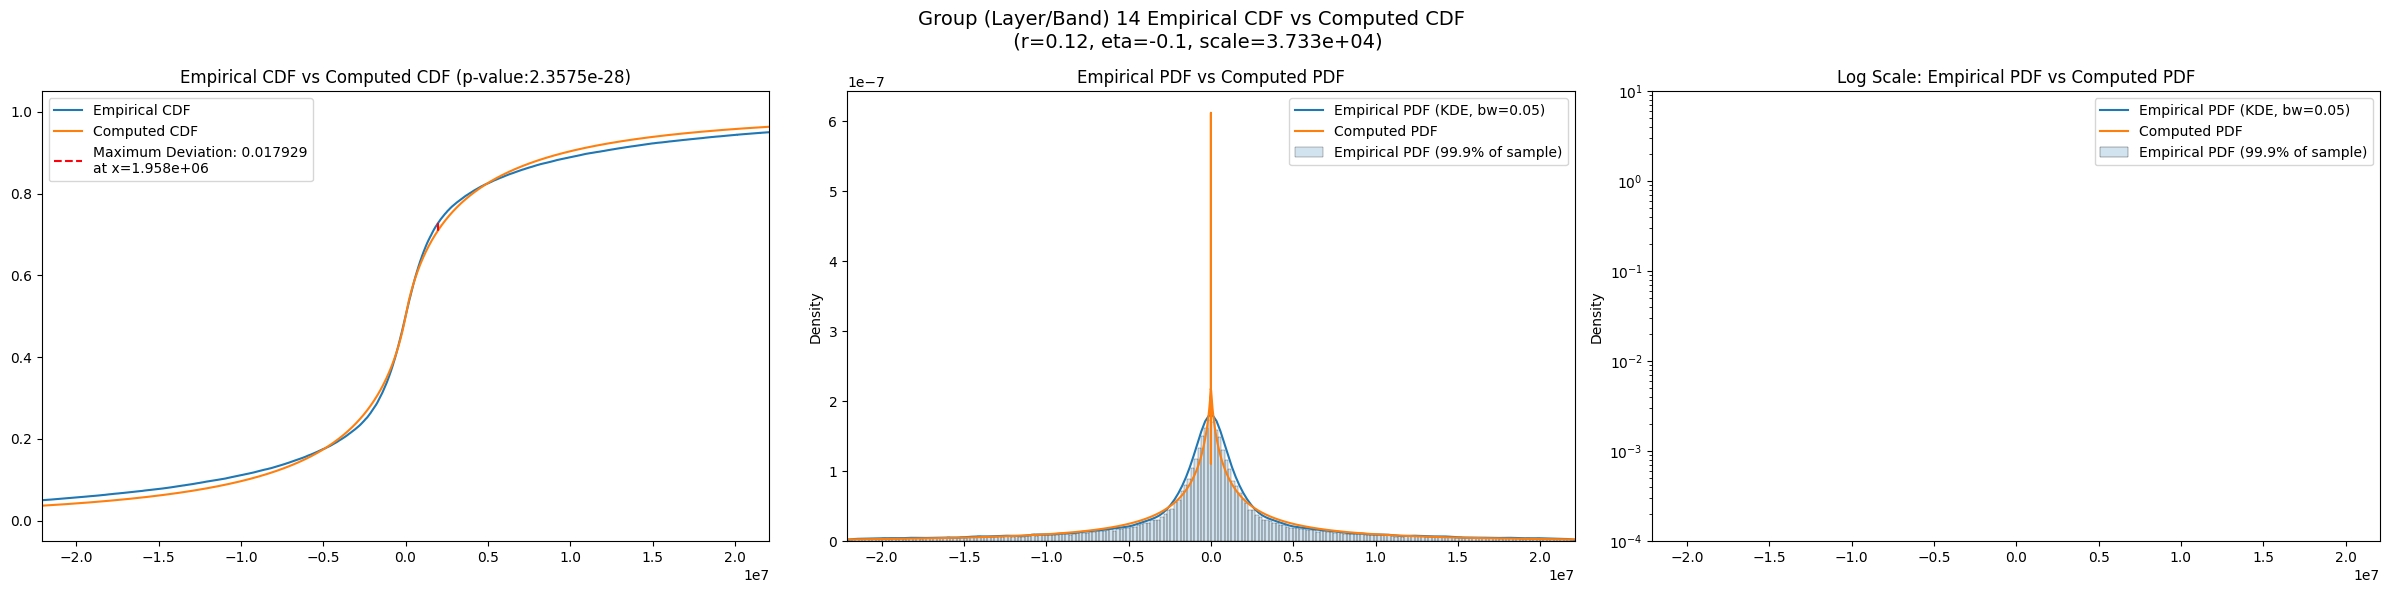

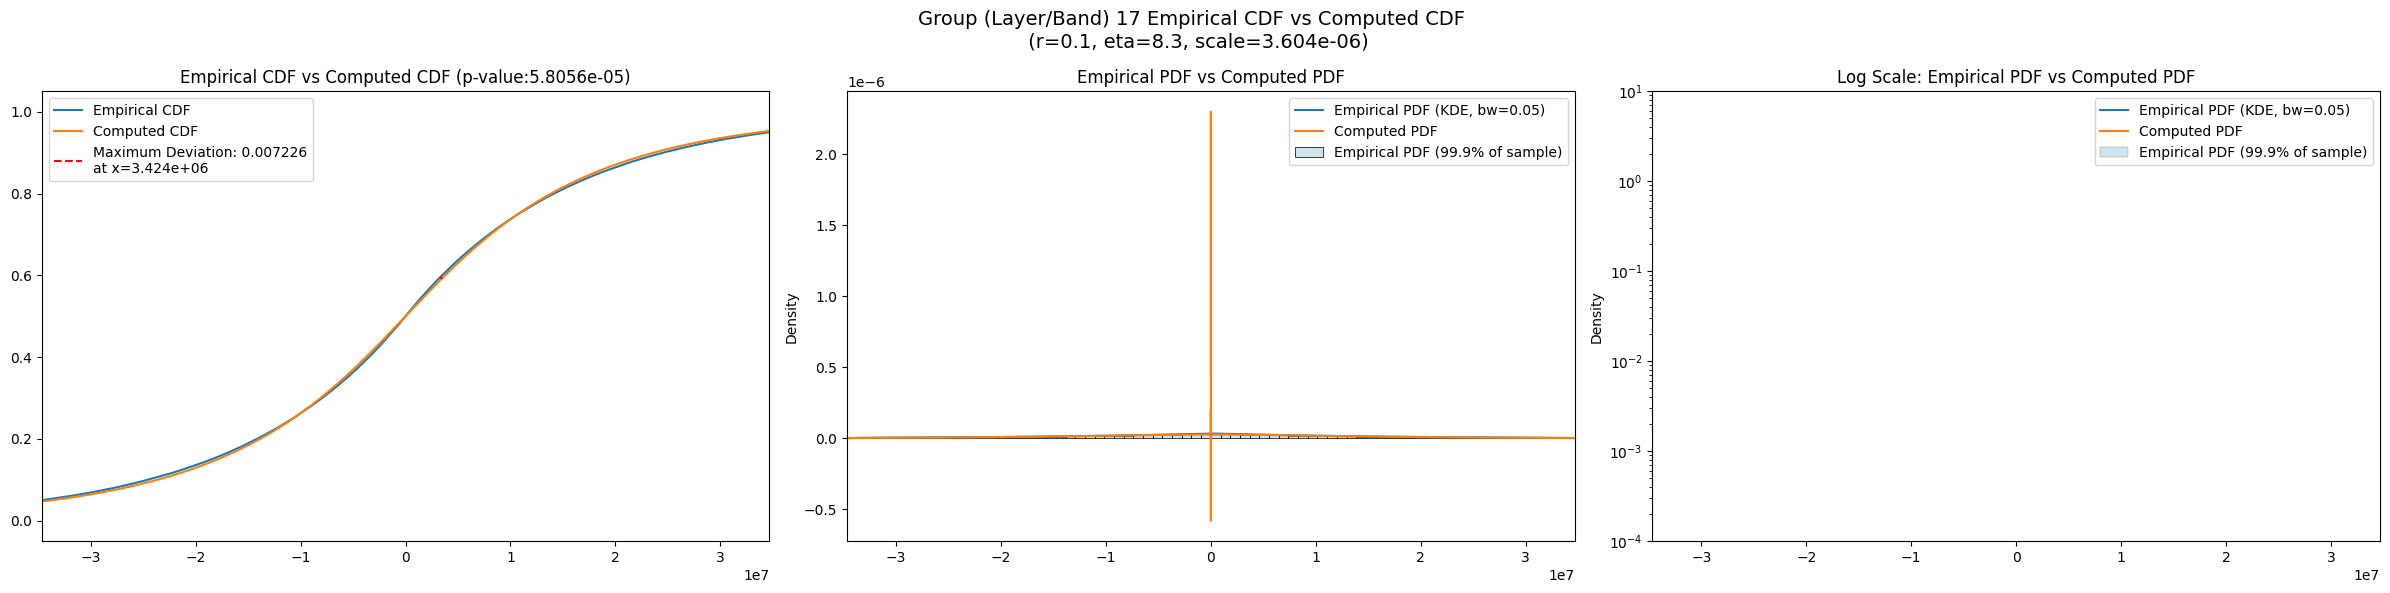

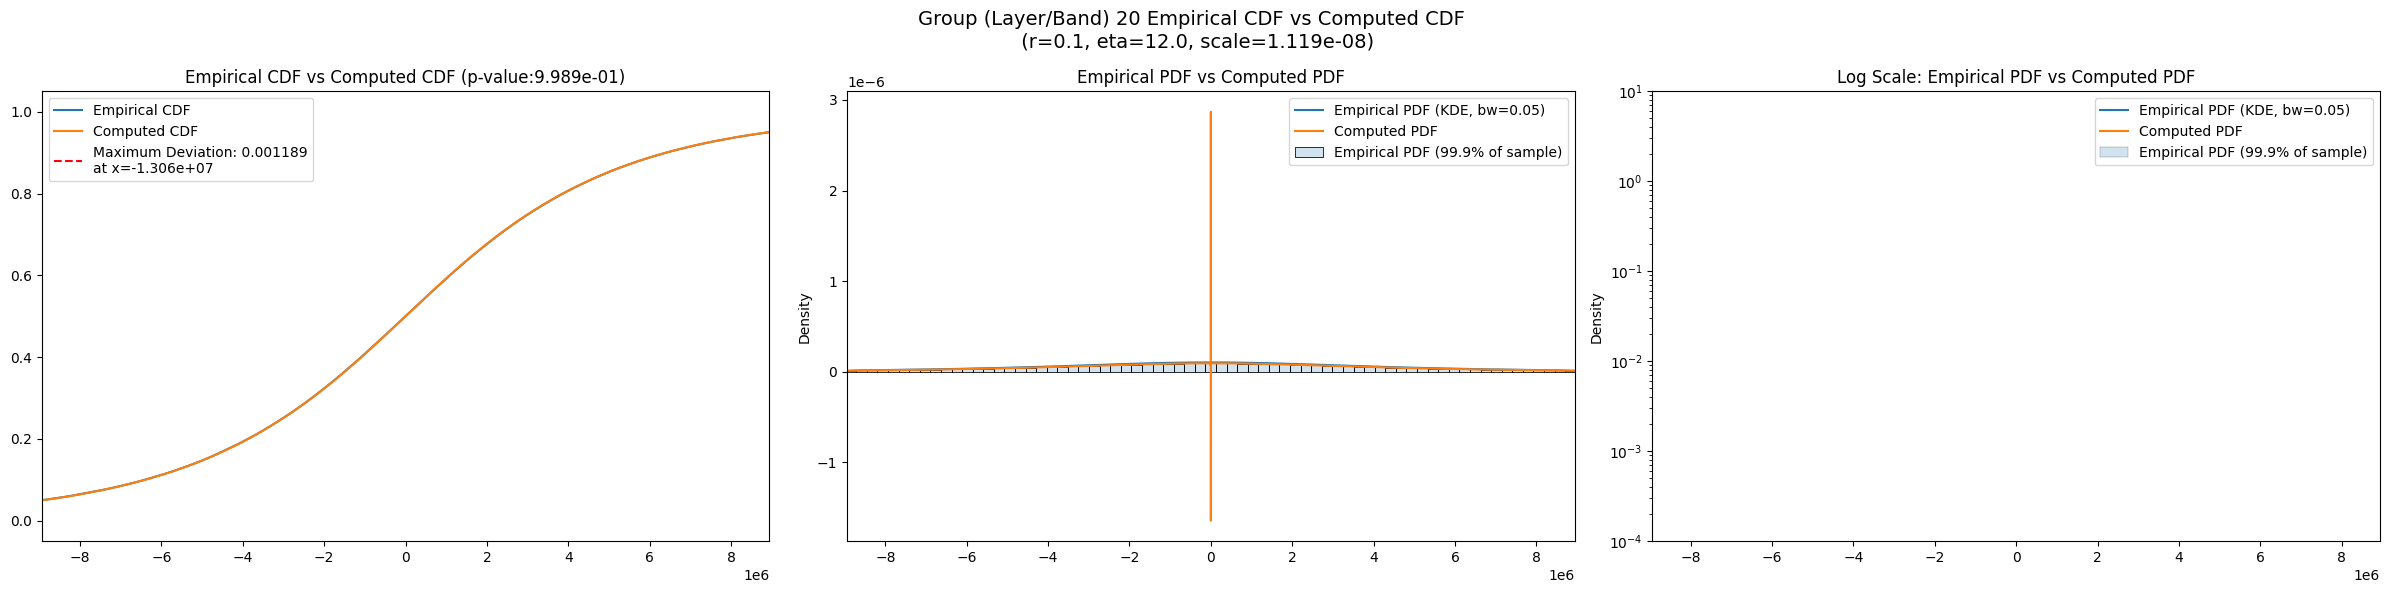

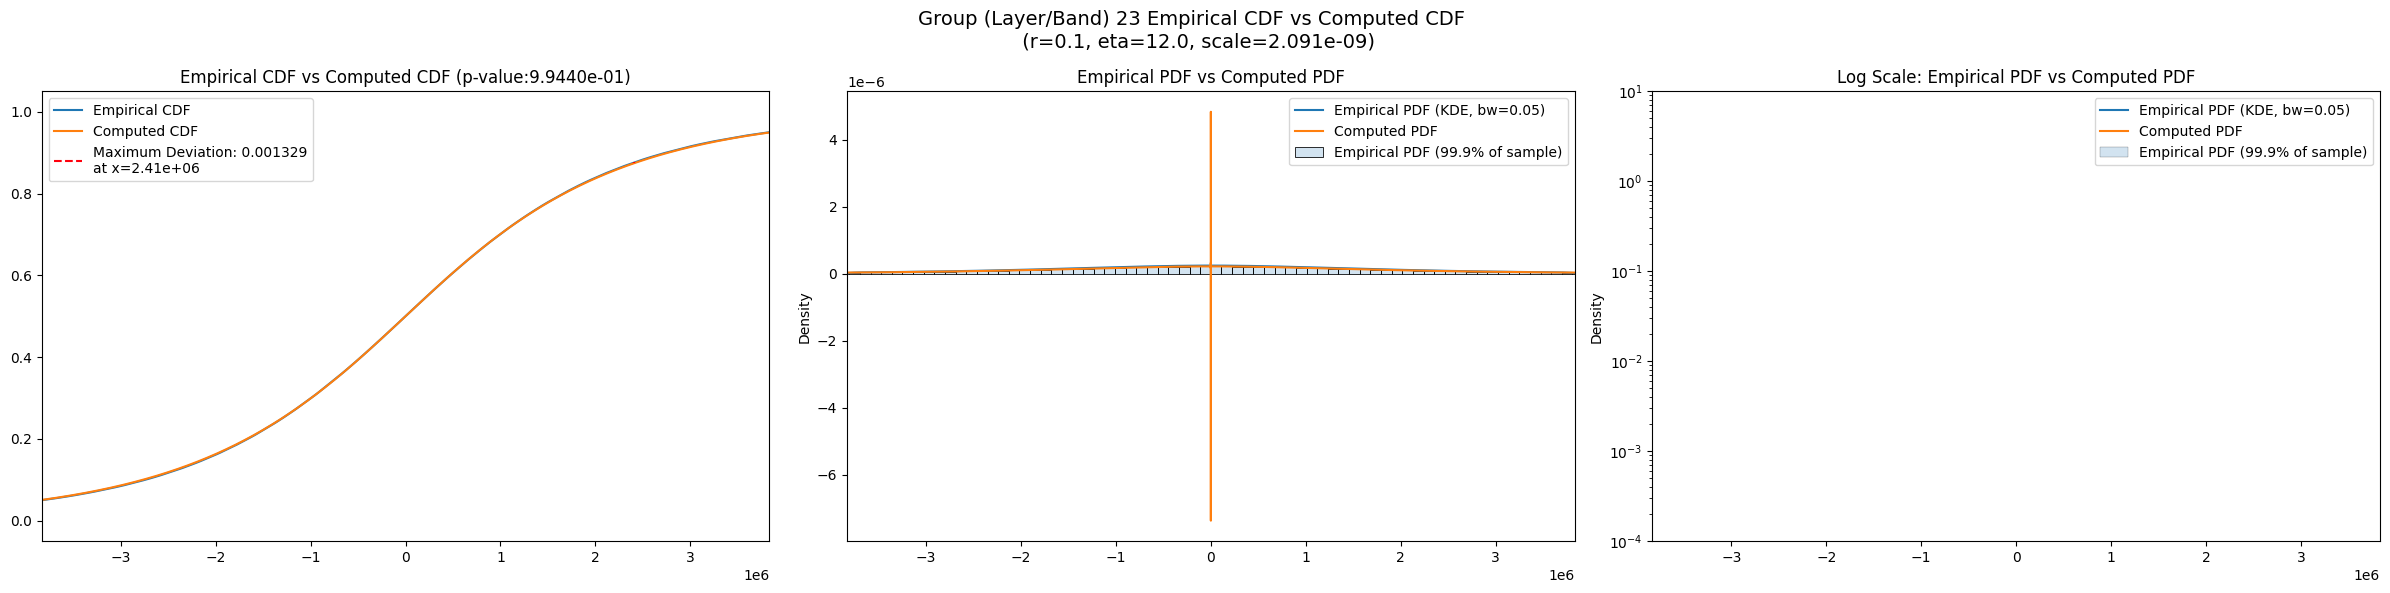

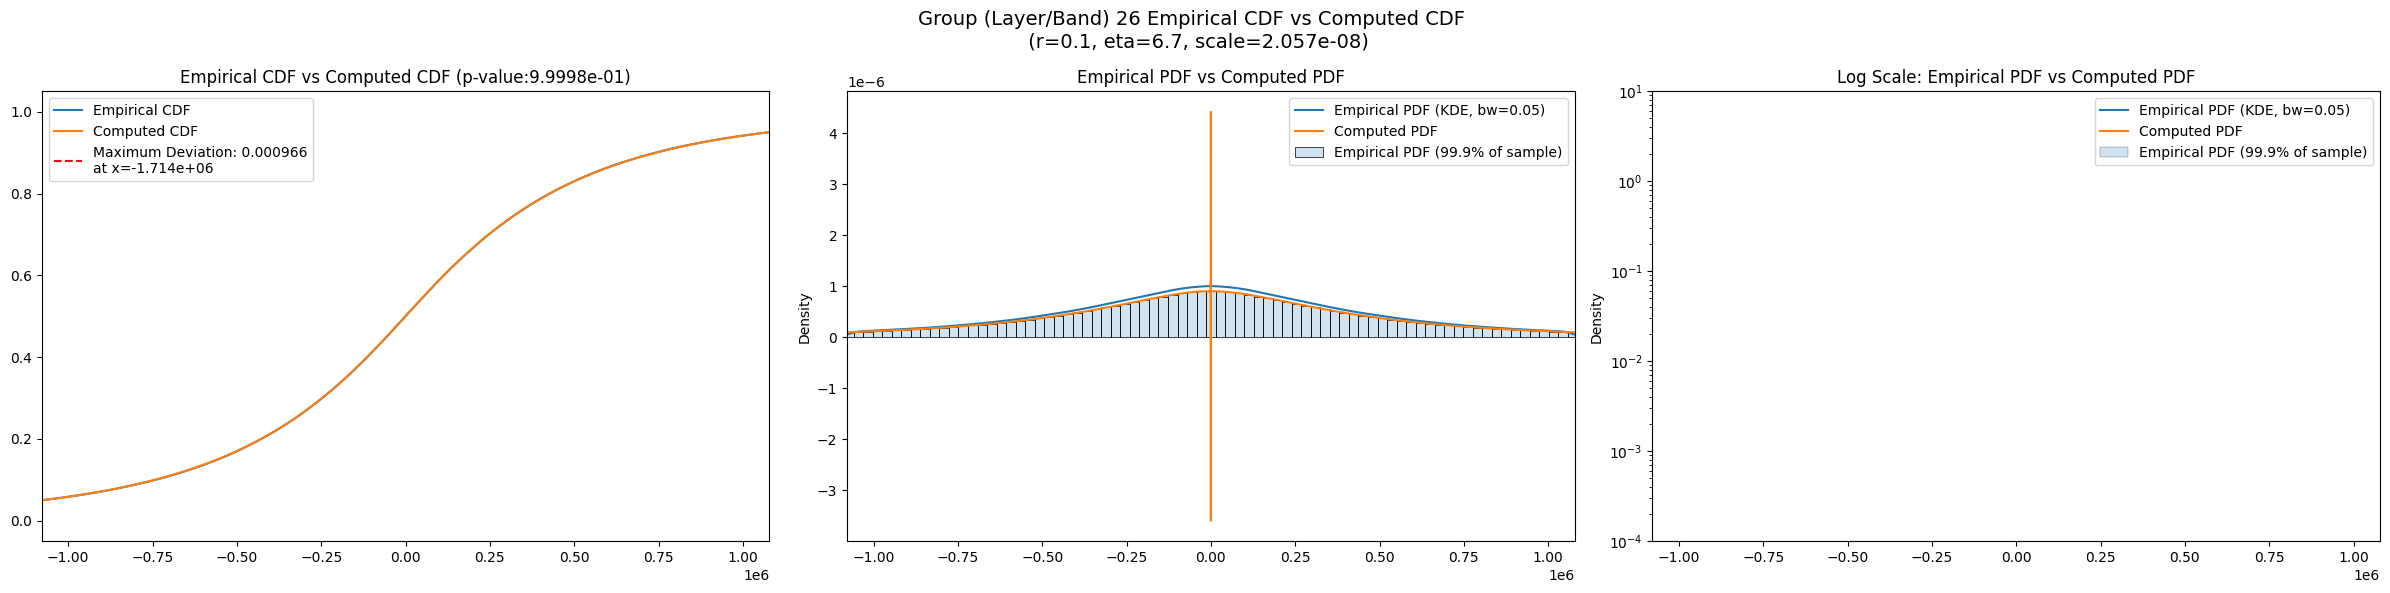

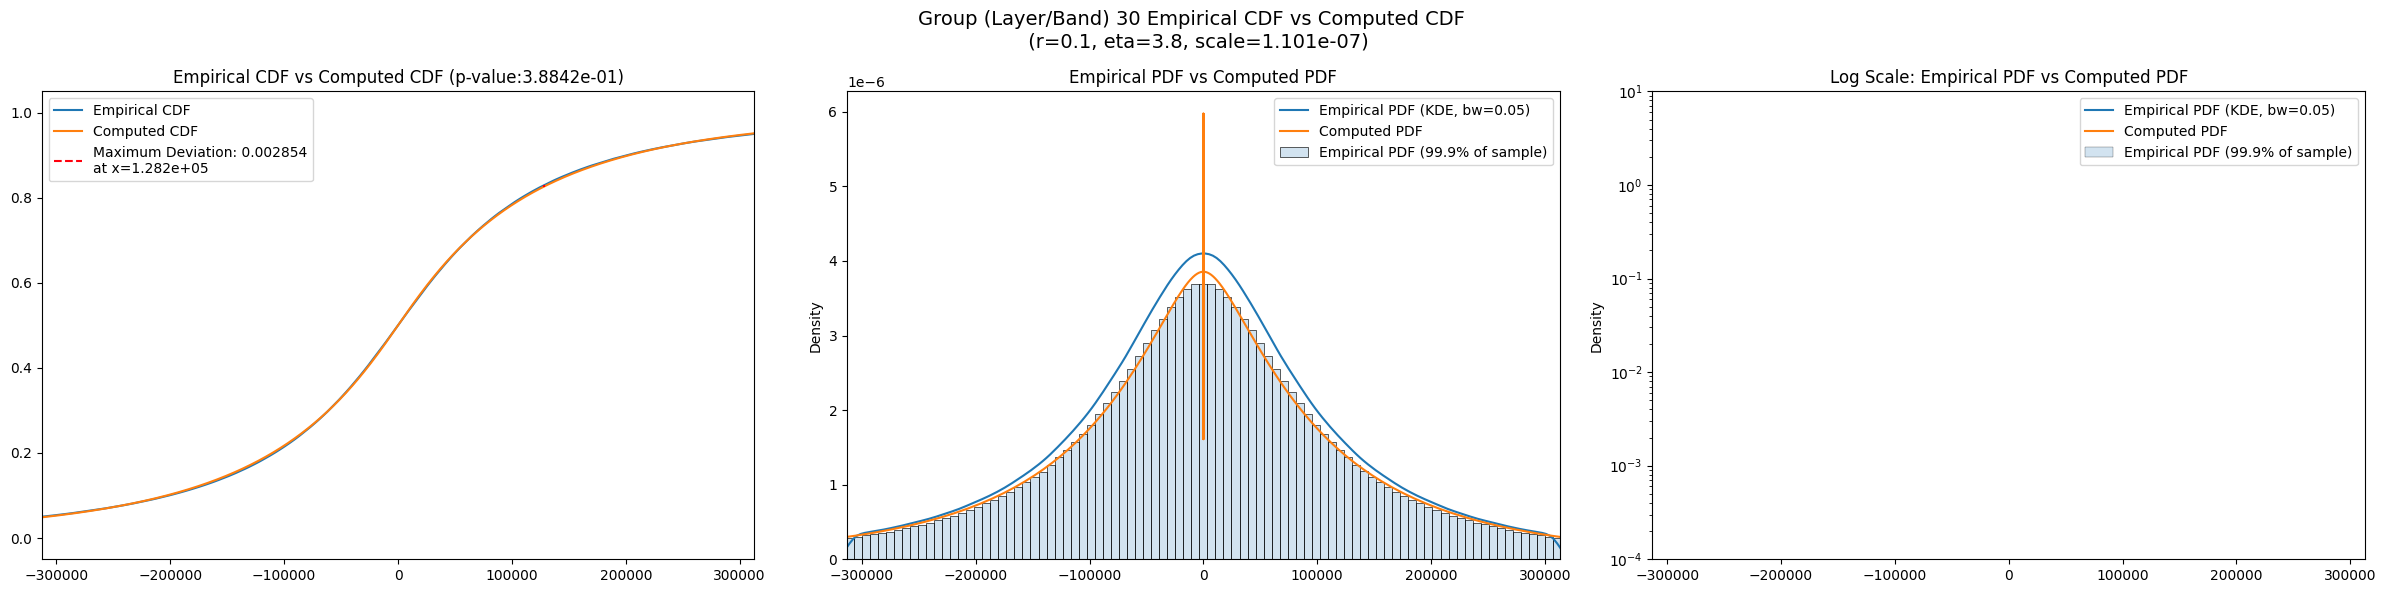

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,3.028180e+14,2.467996e+14,3.692888e+14,6.332603,2.811316,9.789408,672.0,0.013958,0.2,13.0,...,1000000.0,0.415702,1.157880e-105,1000000.0,0.382892,4.090400e-89,1000000.0,0.360930,6.484320e-79,9.992473e-01
5,7.008839e+14,6.244049e+14,7.815991e+14,16.975710,14.058760,20.035242,6720.0,0.014972,0.1,3.2,...,1000000.0,0.408064,0.000000e+00,1000000.0,0.370554,0.000000e+00,1000000.0,0.346850,0.000000e+00,9.925304e-02
8,1.720154e+14,1.501150e+14,1.960864e+14,24.927643,19.883404,30.177086,12768.0,0.011471,0.1,5.4,...,1000000.0,0.347922,0.000000e+00,1000000.0,0.302201,0.000000e+00,1000000.0,0.278166,0.000000e+00,6.892119e-02
11,1.050736e+13,9.690892e+12,1.152692e+13,9.357876,3.100183,21.787817,26208.0,0.003095,0.2,12.0,...,1000000.0,0.222345,0.000000e+00,1000000.0,0.178426,0.000000e+00,1000000.0,0.153379,0.000000e+00,9.747716e-01
14,2.555720e+14,2.280822e+14,2.856580e+14,17.237581,12.749988,23.402639,52416.0,0.018827,0.1,0.2,...,1000000.0,0.248374,0.000000e+00,1000000.0,0.204601,0.000000e+00,1000000.0,0.180808,0.000000e+00,4.565924e-15
17,4.594762e+14,4.331978e+14,4.878664e+14,3.241749,2.217288,6.229757,420672.0,0.007226,0.1,8.3,...,1000000.0,0.421258,0.000000e+00,1000000.0,0.387904,0.000000e+00,1000000.0,0.365014,0.000000e+00,1.663528e-19
20,3.257566e+13,3.055330e+13,3.482894e+13,4.369693,2.560891,8.748408,841344.0,0.001190,0.1,12.0,...,1000000.0,0.303659,0.000000e+00,1000000.0,0.256982,0.000000e+00,1000000.0,0.232837,0.000000e+00,1.845944e-01
23,6.163140e+12,5.720683e+12,6.830977e+12,9.159768,2.926370,42.885918,6730752.0,0.001329,0.1,12.0,...,1000000.0,0.154864,0.000000e+00,1000000.0,0.115666,0.000000e+00,1000000.0,0.089390,0.000000e+00,9.540182e-11
26,5.002160e+11,4.612606e+11,5.505253e+11,9.463871,4.324023,31.556948,3365376.0,0.000966,0.1,6.7,...,548242.0,0.026032,0.000000e+00,477241.0,0.006031,9.580380e-107,387372.0,0.007875,1.011210e-181,3.723460e-03


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.013958,0.052135,0.013958,0.415702,0.382892,0.360930
5,0.014972,0.016542,0.014923,0.408064,0.370554,0.346850
8,0.011471,0.012006,0.011471,0.347922,0.302201,0.278166
11,0.003095,0.008383,0.002965,0.222345,0.178426,0.153379
14,0.018827,0.005929,0.017929,0.248374,0.204601,0.180808
17,0.007226,0.002094,0.007226,0.421258,0.387904,0.365014
20,0.001190,0.001480,0.001190,0.303659,0.256982,0.232837
23,0.001329,0.000523,0.001329,0.154864,0.115666,0.089390
26,0.000966,0.000740,0.000966,0.026032,0.006031,0.007875


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,3.028180e+14,0.013958,0.20,13.0,1.000000e+05,0.0
5,3.606243e+14,0.014923,0.11,3.1,2.878721e-01,125.0
8,8.212705e+13,0.011471,0.10,5.4,1.798595e-05,200.0
11,9.314053e+12,0.002965,0.18,12.0,3.023077e+02,75.0
14,2.555720e+14,0.017929,0.12,-0.1,3.733190e+04,0.0
17,4.594762e+14,0.007226,0.10,8.3,3.603551e-06,0.0
20,3.115787e+13,0.001190,0.10,12.0,1.118785e-08,50.0
23,5.823431e+12,0.001329,0.10,12.0,2.091018e-09,50.0
26,4.796538e+11,0.000966,0.10,6.7,2.056664e-08,25.0
